# Synthetic data generation with GAN and VAE neural networks for a system of making strategically grounded decisions

## Setup Environment

In [40]:
%load_ext autoreload
%reload_ext autoreload
%autoreload 2
# Time module
import time
import warnings  # todo exclude

# Data structures and analysis tools
import pandas as pd

# Numerical computing
import numpy as np

# Plots and visualization
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

# Statistical functions, time-series models
from scipy.stats import (
    boxcox,
    ks_2samp,
    entropy,
    wasserstein_distance,
    chi2_contingency,
)
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, f1_score
# Seasonal ARIMA time-series forecasting
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.impute import SimpleImputer

# Transformer logic
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer

# Train-test splitting
from sklearn.model_selection import train_test_split

# Principal component analysis
from sklearn.decomposition import PCA

# Logistic Regression classifier
from sklearn.linear_model import LogisticRegression

# Evaluation metrics(Scikit-learn)
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    mean_absolute_error,
    mean_absolute_percentage_error,
    mean_squared_error,
    roc_curve,
    roc_auc_score,
)

# Generation of a string data type
from faker import Faker

# Project modules
from gan import GAN, GanConfig, TrainingConfig as GanTrainingConfig, SchedulerConfig
from vae import VAE, VaeConfig, TrainingConfig as VaeTrainingConfig
from models.enums import DataType
from models.field_metadata import FieldMetadata

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Airline Dataset

In [2]:
airline_dataset = pd.read_csv(
    "datasets/airline-passenger-satisfaction.csv", parse_dates=["Date"]
).dropna()
print(f"Rows count in dataset: {airline_dataset.shape[0]}")
print(f"Column amount: {airline_dataset.shape[1]}")
display(airline_dataset.head(10))

Rows count in dataset: 103594
Column amount: 25


City       Date  Gender      Customer Type  Age   Type of Travel  \
0       Austin 2019-07-13    Male     Loyal Customer   13  Personal Travel   
1     San Jose 2017-07-26    Male  disloyal Customer   25  Business travel   
2      Seattle 2018-08-27  Female     Loyal Customer   26  Business travel   
3  San Antonio 2018-04-21  Female     Loyal Customer   25  Business travel   
4       Austin 2019-05-30    Male     Loyal Customer   61  Business travel   
5      Seattle 2018-09-23  Female     Loyal Customer   26  Personal Travel   
6       Dallas 2019-09-21    Male     Loyal Customer   47  Personal Travel   
7       Austin 2018-07-12  Female     Loyal Customer   52  Business travel   
8       Denver 2019-03-08  Female     Loyal Customer   41  Business travel   
9       Denver 2019-10-14    Male  disloyal Customer   20  Business travel   

      Class  Flight Distance  Inflight wifi service  \
0  Eco Plus              460                      3   
1  Business              235                      3   
2  Business             1142                      2   
3  Business              562                      2   
4  Business              214                      3   
5       Eco             1180                      3   
6       Eco             1276                      2   
7  Business             2035                      4   
8  Business              853                      1   
9       Eco             1061                      3   

   Departure or Arrival time convenient  ...  Inflight entertainment  \
0                                     4  ...                       5   
1                                     2  ...                       1   
2                                     2  ...                       5   
3                                     5  ...                       2   
4                                     3  ...                       3   
5                                     4  ...                       1   
6                                     4  ...                       2   
7                                     3  ...                       5   
8                                     2  ...                       1   
9                                     3  ...                       2   

   On-board service  Leg room service  Baggage handling  Checkin service  \
0                 4                 3                 4                4   
1                 1                 5                 3                1   
2                 4                 3                 4                4   
3                 2                 5                 3                1   
4                 3                 4                 4                3   
5                 3                 4                 4                4   
6                 3                 3                 4                3   
7                 5                 5                 5                4   
8                 1                 2                 1                4   
9                 2                 3                 4                4   

   Inflight service  Cleanliness  Departure Delay in Minutes  \
0                 5            5                          25   
1                 4            1                           1   
2                 4            5                           0   
3                 4            2                          11   
4                 3            3                           0   
5                 4            1                           0   
6                 5            2                           9   
7                 5            4                           4   
8                 1            2                           0   
9                 3            2                           0   

   Arrival Delay in Minutes  is_satisfied  
0                      18.0             0  
1                       6.0             0  
2                       0.0             1  
3                       9.0       

### Overview of dataset column info

In [3]:
print(airline_dataset.info())

<class 'pandas.core.frame.DataFrame'>
Index: 103594 entries, 0 to 103903
Data columns (total 25 columns):
 #   Column                                Non-Null Count   Dtype         
---  ------                                --------------   -----         
 0   City                                  103594 non-null  object        
 1   Date                                  103594 non-null  datetime64[ns]
 2   Gender                                103594 non-null  object        
 3   Customer Type                         103594 non-null  object        
 4   Age                                   103594 non-null  int64         
 5   Type of Travel                        103594 non-null  object        
 6   Class                                 103594 non-null  object        
 7   Flight Distance                       103594 non-null  int64         
 8   Inflight wifi service                 103594 non-null  int64         
 9   Departure or Arrival time convenient  103594 non-null  int64    

### Synthetic Data Generation

#### Metadata for GAN and VAE networks, that describe types of data and methods of their generation

In [4]:
airline_metadata = {
    "City": FieldMetadata(DataType.STRING, faker_method=Faker().city),
    "Date": FieldMetadata(DataType.DATETIME, datetime_format="%Y-%m-%d"),
    "Gender": FieldMetadata(DataType.CATEGORICAL),
    "Customer Type": FieldMetadata(DataType.CATEGORICAL),
    "Age": FieldMetadata(DataType.INTEGER),
    "Type of Travel": FieldMetadata(DataType.CATEGORICAL),
    "Class": FieldMetadata(DataType.CATEGORICAL),
    "Flight Distance": FieldMetadata(DataType.INTEGER),
    "Inflight wifi service": FieldMetadata(DataType.INTEGER),
    "Departure or Arrival time convenient": FieldMetadata(DataType.INTEGER),
    "Ease of Online booking": FieldMetadata(DataType.INTEGER),
    "Gate location": FieldMetadata(DataType.INTEGER),
    "Food and drink": FieldMetadata(DataType.INTEGER),
    "Online boarding": FieldMetadata(DataType.INTEGER),
    "Seat comfort": FieldMetadata(DataType.INTEGER),
    "Inflight entertainment": FieldMetadata(DataType.INTEGER),
    "On-board service": FieldMetadata(DataType.INTEGER),
    "Leg room service": FieldMetadata(DataType.INTEGER),
    "Baggage handling": FieldMetadata(DataType.INTEGER),
    "Checkin service": FieldMetadata(DataType.INTEGER),
    "Inflight service": FieldMetadata(DataType.INTEGER),
    "Cleanliness": FieldMetadata(DataType.INTEGER),
    "Departure Delay in Minutes": FieldMetadata(DataType.INTEGER),
    "Arrival Delay in Minutes": FieldMetadata(DataType.DECIMAL, decimal_places=1),
    "is_satisfied": FieldMetadata(DataType.BOOLEAN),
}

#### Define lists of columns by type for statistical analysis after data generation

In [5]:
airline_num_cols = [
    col
    for col, meta in airline_metadata.items()
    if meta.data_type in {DataType.INTEGER, DataType.DECIMAL}
]
airline_cat_cols = [
    col
    for col, meta in airline_metadata.items()
    if meta.data_type in {DataType.CATEGORICAL, DataType.BOOLEAN}
]
airline_datetime_cols = [
    col for col, meta in airline_metadata.items() if meta.data_type == DataType.DATETIME
]
airline_string_cols = [
    col for col, meta in airline_metadata.items() if meta.data_type == DataType.STRING
]

#### Training process of GAN and VAE networks

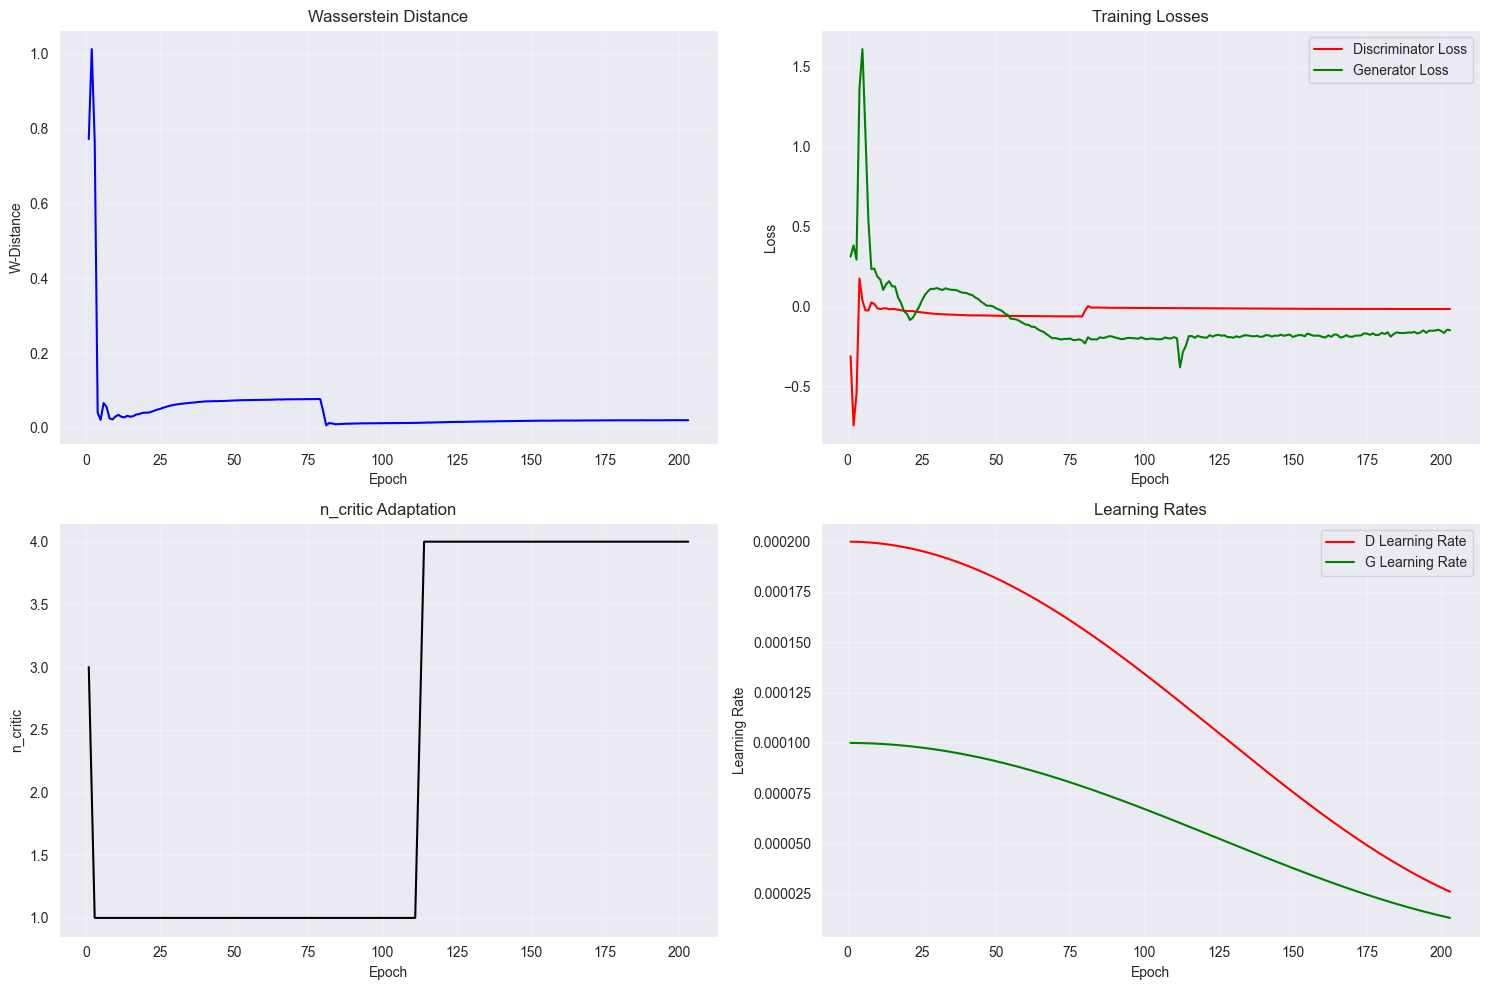

Training completed in 1841.06 seconds


In [8]:
start_time = time.time()

cfg = GanConfig(
    training=GanTrainingConfig(epochs=250, verbose=True),
    scheduler=SchedulerConfig(patience=200),
)
# Creating a GAN pipeline with GAN Config class
gan_model = GAN(airline_dataset, airline_metadata, cfg)
# Training a GAN model with training plots
gan_model.fit()
# Generating synthetic data
airline_gan_dataset = gan_model.generate(len(airline_dataset) // 2)

print(f"Training completed in {time.time() - start_time:.2f} seconds")

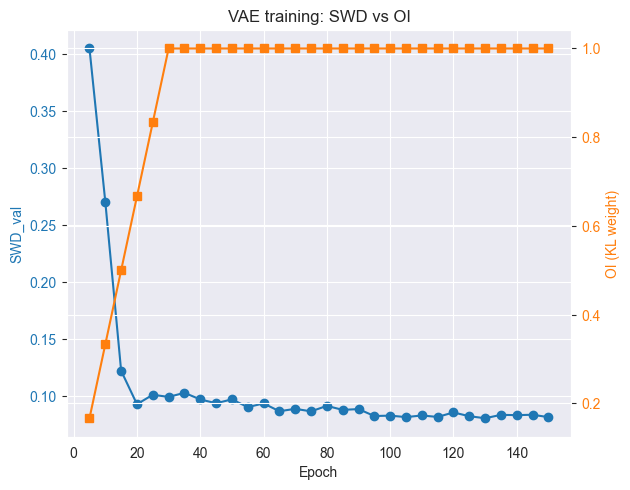

Training completed in 1387.84 seconds


In [177]:
warnings.simplefilter(action="ignore", category=UserWarning)
start_time = time.time()
# Creating a VAE pipeline
vae_model = VAE(
    airline_dataset,
    airline_metadata,
    VaeConfig(training=VaeTrainingConfig(epochs=150, verbose=True)),
)
# Training a VAE model with training plots
vae_model.fit()
# Generating synthetic data
airline_vae_dataset = vae_model.generate(len(airline_dataset) // 2)

print(f"Training completed in {time.time() - start_time:.2f} seconds")

### Quality Analysis

#### Original dataset - numeric columns

In [178]:
display(airline_dataset[airline_num_cols].describe())

Age  Flight Distance  Inflight wifi service  \
count  103594.000000    103594.000000          103594.000000   
mean       39.380466      1189.325202               2.729753   
std        15.113125       997.297235               1.327866   
min         7.000000        31.000000               0.000000   
25%        27.000000       414.000000               2.000000   
50%        40.000000       842.000000               3.000000   
75%        51.000000      1743.000000               4.000000   
max        85.000000      4983.000000               5.000000   

       Departure or Arrival time convenient  Ease of Online booking  \
count                         103594.000000           103594.000000   
mean                               3.060081                2.756984   
std                                1.525233                1.398934   
min                                0.000000                0.000000   
25%                                2.000000                2.000000   
50%                                3.000000                3.000000   
75%                                4.000000                4.000000   
max                                5.000000                5.000000   

       Gate location  Food and drink  Online boarding   Seat comfort  \
count  103594.000000   103594.000000    103594.000000  103594.000000   
mean        2.977026        3.202126         3.250497       3.439765   
std         1.277723        1.329401         1.349433       1.318896   
min         0.000000        0.000000         0.000000       0.000000   
25%         2.000000        2.000000         2.000000       2.000000   
50%         3.000000        3.000000         3.000000       4.000000   
75%         4.000000        4.000000         4.000000       5.000000   
max         5.000000        5.000000         5.000000       5.000000   

       Inflight entertainment  On-board service  Leg room service  \
count           103594.000000     103594.000000     103594.000000   
mean                 3.358341          3.382609          3.351401   
std                  1.333030          1.288284          1.315409   
min                  0.000000          0.000000          0.000000   
25%                  2.000000          2.000000          2.000000   
50%                  4.000000          4.000000          4.000000   
75%                  4.000000          4.000000          4.000000   
max                  5.000000          5.000000          5.000000   

       Baggage handling  Checkin service  Inflight service    Cleanliness  \
count     103594.000000    103594.000000     103594.000000  103594.000000   
mean           3.631687         3.304323          3.640761       3.286397   
std            1.181051         1.265396          1.175603       1.312194   
min            1.000000         0.000000          0.000000       0.000000   
25%            3.000000         3.000000          3.000000       2.000000   
50%            4.000000         3.000000          4.000000       3.000000   
75%            5.000000         4.000000          5.000000       4.000000   
max            5.000000         5.000000          5.000000       5.000000   

       Departure Delay in Minutes  Arrival Delay in Minutes  
count               103594.000000             103594.000000  
mean                    14.747939                 15.178678  
std                     38.116737                 38.698682  
min                      0.000000                  0.000000  
25%                      0.000000                  0.000000  
50%                      0.000000                  0.000000  
75%                     12.000000                 13.000000  
max                   1592.000000               1584.000000

#### Statistical metrics of synthetic and original dataset

##### Utility Methods for statistic comparison

In [166]:
def _kl_divergence(hist_ref, hist_cmp, eps=1e-10):
    """Symmetric KL with smoothing to avoid log(0)"""
    return 0.5 * (
        entropy(hist_ref + eps, hist_cmp + eps)
        + entropy(hist_cmp + eps, hist_ref + eps)
    )


def _safe_hist(series, bins=50):
    """Histogram with fixed bin-edges (for KL and Wasserstein)."""
    counts, edges = np.histogram(series, bins=bins, density=True)
    return counts, edges


def _value_counts(series):
    """Consistent index type (str) so union / reindex is stable."""
    return series.astype("object").astype(str).value_counts()

##### Statistical comparison of numeric fields in two synthetic datasets

In [179]:
numeric_metrics = []

for col, meta in airline_metadata.items():
    if col not in airline_num_cols:
        continue

    real = airline_dataset[col].to_numpy()
    gan = airline_gan_dataset[col].to_numpy()
    vae = airline_vae_dataset[col].to_numpy()

    # Wasserstein
    w_gan, w_vae = wasserstein_distance(real, gan), wasserstein_distance(real, vae)

    # KS
    ks_gan, ks_vae = ks_2samp(real, gan), ks_2samp(real, vae)

    # KL on equal bins
    hist_r, bins = _safe_hist(real)
    hist_g, _ = np.histogram(gan, bins=bins, density=True)
    hist_v, _ = np.histogram(vae, bins=bins, density=True)
    kl_gan, kl_vae = _kl_divergence(hist_r, hist_g), _kl_divergence(hist_r, hist_v)

    numeric_metrics.append(
        {
            "field": col,
            "W_gan": w_gan,
            "KS_gan_stat": ks_gan.statistic,
            "KS_gan_p": ks_gan.pvalue,
            "KL_gan": kl_gan,
            "W_vae": w_vae,
            "KS_vae_stat": ks_vae.statistic,
            "KS_vae_p": ks_vae.pvalue,
            "KL_vae": kl_vae,
        }
    )

display(pd.DataFrame(numeric_metrics).set_index("field").sort_index())

W_gan  KS_gan_stat      KS_gan_p  \
field                                                                        
Age                                    0.438520     0.015522  1.174148e-07   
Arrival Delay in Minutes               0.799950     0.051383  1.123824e-79   
Baggage handling                       0.047271     0.018466  1.167151e-10   
Checkin service                        0.102419     0.033834  8.876579e-35   
Cleanliness                            0.029567     0.011593  1.846391e-04   
Departure Delay in Minutes             0.670521     0.050447  8.204729e-77   
Departure or Arrival time convenient   0.062378     0.021208  6.361387e-14   
Ease of Online booking                 0.042194     0.015899  5.185472e-08   
Flight Distance                       53.198245     0.033371  7.634941e-34   
Food and drink                         0.020995     0.012481  4.214663e-05   
Gate location                          0.044346     0.018322  1.686390e-10   
Inflight entertainment                 0.033670     0.018621  7.856948e-11   
Inflight service                       0.060052     0.020966  1.285123e-13   
Inflight wifi service                  0.038574     0.012385  4.974964e-05   
Leg room service                       0.092544     0.029838  3.843741e-27   
On-board service                       0.058864     0.022405  1.726374e-15   
Online boarding                        0.057339     0.017260  2.294070e-09   
Seat comfort                           0.034568     0.015908  5.076631e-08   

                                        KL_gan      W_vae  KS_vae_stat  \
field                                                                    
Age                                   0.016341   0.783540     0.027646   
Arrival Delay in Minutes              0.013866   3.785007     0.089802   
Baggage handling                      0.003099   0.163591     0.059704   
Checkin service                       0.010985   0.134100     0.048864   
Cleanliness                           0.002777   0.154826     0.050128   
Departure Delay in Minutes            0.012006   3.922988     0.088615   
Departure or Arrival time convenient  0.008005   0.184103     0.063681   
Ease of Online booking                0.005466   0.209752     0.060090   
Flight Distance                       0.016516  37.907997     0.022482   
Food and drink                        0.010519   0.152644     0.049588   
Gate location                         0.002500   0.148039     0.048227   
Inflight entertainment                0.003484   0.248663     0.079696   
Inflight service                      0.003657   0.159671     0.059994   
Inflight wifi service                 0.003836   0.245709     0.080304   
Leg room service                      0.007287   0.163745     0.053854   
On-board service                      0.003790   0.181420     0.058700   
Online boarding                       0.003807   0.190204     0.058285   
Seat comfort                          0.001959   0.199925     0.062031   

                                           KS_vae_p    KL_vae  
field                                                          
Age                                    2.316083e-23  0.016836  
Arrival Delay in Minutes              9.140855e-243  0.018201  
Baggage handling                      1.931021e-107  0.027611  
Checkin service                        4.317044e-72  0.021919  
Cleanliness                            7.519141e-76  0.026115  
Departure Delay in Minutes            2.176133e-236  0.017577  
Departure or Arrival time convenient  3.480787e-122  0.033300  
Ease of Online booking                7.872547e-109  0.042853  
Flight Distance                        1.358696e-15  0.012204  
Food and drink                         3.125025e-74  0.033153  
Gate location                          3.108765e-70  0.023762  
Inflight entertainment                3.235511e-191  0.061106  
Inflight service                      1.755398e-108  0.026648  
Inflight wifi service                 3.

##### Statistical comparison of categorical fields in two synthetic datasets

In [180]:
categorical_metrics = []

for col, meta in airline_metadata.items():
    if col not in airline_cat_cols:
        continue

    # raw counts
    real_ct = _value_counts(airline_dataset[col])
    gan_ct  = _value_counts(airline_gan_dataset[col])
    vae_ct  = _value_counts(airline_vae_dataset[col])

    # align categories
    cats = sorted(set(real_ct.index) | set(gan_ct.index) | set(vae_ct.index))
    real_counts = real_ct.reindex(cats, fill_value=0)
    gan_counts  = gan_ct.reindex(cats,  fill_value=0)
    vae_counts  = vae_ct.reindex(cats,  fill_value=0)

    # 1) absolute-count MAE (as before)
    mae_count_gan = mean_absolute_error(real_counts, gan_counts)
    mae_count_vae = mean_absolute_error(real_counts, vae_counts)

    # 2) proportion vectors
    real_prop = real_counts / real_counts.sum()
    gan_prop  = gan_counts  / gan_counts.sum()
    vae_prop  = vae_counts  / vae_counts.sum()

    # 3) scale-free MAE on proportions
    mae_prop_gan = mean_absolute_error(real_prop, gan_prop)
    mae_prop_vae = mean_absolute_error(real_prop, vae_prop)

    # 4) Jensen–Shannon divergence
    #    JSD(P||Q) = ½[KL(P||M) + KL(Q||M)]  where M = ½(P+Q)
    m_g = 0.5 * (real_prop + gan_prop)
    jsd_gan = 0.5 * (entropy(real_prop, m_g) + entropy(gan_prop, m_g))

    m_v = 0.5 * (real_prop + vae_prop)
    jsd_vae = 0.5 * (entropy(real_prop, m_v) + entropy(vae_prop, m_v))

    # 5) χ² test on raw counts
    cont_gan = np.vstack([real_counts, gan_counts])
    cont_vae = np.vstack([real_counts, vae_counts])
    chi_g_stat, chi_g_p, _, _ = chi2_contingency(cont_gan)
    chi_v_stat, chi_v_p, _, _ = chi2_contingency(cont_vae)

    categorical_metrics.append({
        "field":          col,
        "MAE_count_gan":  mae_count_gan,
        "MAE_count_vae":  mae_count_vae,
        "MAE_prop_gan":   mae_prop_gan,
        "MAE_prop_vae":   mae_prop_vae,
        "JSD_gan":        jsd_gan,
        "JSD_vae":        jsd_vae,
        "Chi2_gan_stat":  chi_g_stat,
        "Chi2_vae_stat":  chi_v_stat,
        "Chi2_gan_p":     chi_g_p,
        "Chi2_vae_p":     chi_v_p,
    })

df_metrics = pd.DataFrame(categorical_metrics).set_index("field").sort_index()
display(df_metrics)

MAE_count_gan  MAE_count_vae  MAE_prop_gan  MAE_prop_vae  \
field                                                                      
Class            17265.666667   17265.666667      0.001487      0.020979   
Customer Type    25898.500000   25898.500000      0.002182      0.033361   
Gender           25898.500000   25898.500000      0.000695      0.001294   
Type of Travel   25898.500000   25898.500000      0.004257      0.016632   
is_satisfied     25898.500000   25898.500000      0.002037      0.030243   

                     JSD_gan       JSD_vae  Chi2_gan_stat  Chi2_vae_stat  \
field                                                                      
Class           3.012552e-06  2.384503e-03       0.831902     599.238266   
Customer Type   4.001886e-06  1.005959e-03       1.089197     270.080880   
Gender          2.415768e-07  8.367440e-07       0.063984       0.226008   
Type of Travel  1.054802e-05  1.641086e-04       2.897692      45.018821   
is_satisfied    2.112924e-06  4.622966e-04       0.575319     127.848367   

                Chi2_gan_p     Chi2_vae_p  
field                                      
Class             0.659712  7.534664e-131  
Customer Type     0.296649   1.089637e-60  
Gender            0.800306   6.345000e-01  
Type of Travel    0.088706   1.951498e-11  
is_satisfied      0.448153   1.211545e-29

##### Analytics on string data type generation

In [181]:
orig_names = airline_dataset['City'].value_counts().nlargest(20).index.tolist()
gan_names = airline_gan_dataset['City'].value_counts().nlargest(20).index.tolist()
vae_names = airline_vae_dataset['City'].value_counts().nlargest(20).index.tolist()

max_len = 20
def pad(lst):
    return lst + [None] * (max_len - len(lst))

data = {
    "Original": pad(orig_names),
    "GAN": pad(gan_names),
    "VAE": pad(vae_names)
}

df = pd.DataFrame(data)
df.index = range(1, max_len + 1)
df.index.name = f"Rank"
display(df)

Original            GAN               VAE
Rank                                                
1            Denver    New Michael      East Michael
2      Indianapolis   Lake Michael      Port Michael
3           Seattle   East Michael     North Michael
4          San Jose     Smithmouth        West James
5          Columbus  South Michael       North James
6         Charlotte   Port Michael     Port Jennifer
7        Washington    South David      Lake Michael
8       San Antonio   Michaelmouth      West Michael
9      Jacksonville      East John         Port John
10        San Diego     Port James         East John
11         New York  North Michael        Jamesmouth
12    San Francisco     East David       North David
13          Chicago   New Jennifer        Port James
14          Houston    North David         New David
15      Los Angeles      New David     South Michael
16     Philadelphia    Port Robert  Lake Christopher
17           Austin    Lake Robert          New John
18          Phoenix     South John       New Michael
19           Dallas    South James      North Robert
20       Fort Worth   West Michael        Lake David

##### Distributions comparison of numeric columns

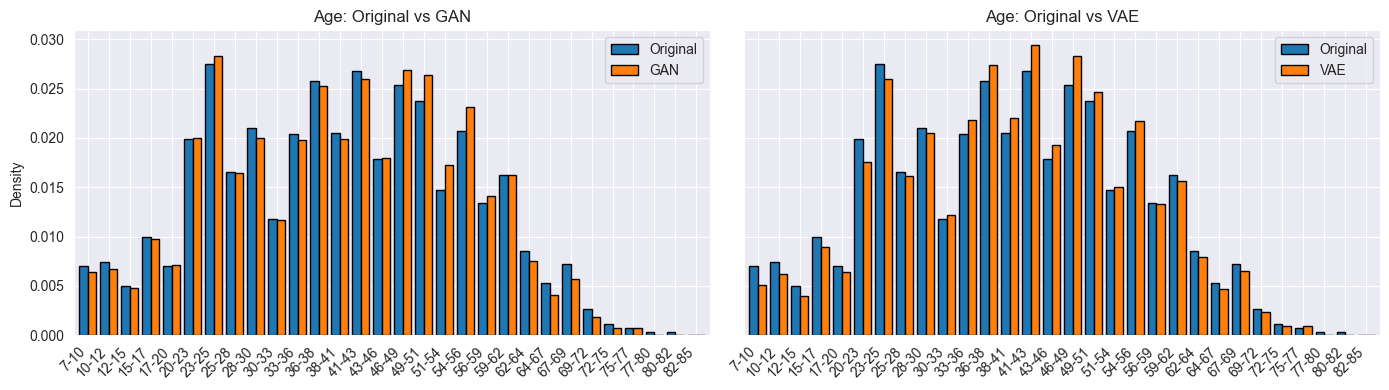

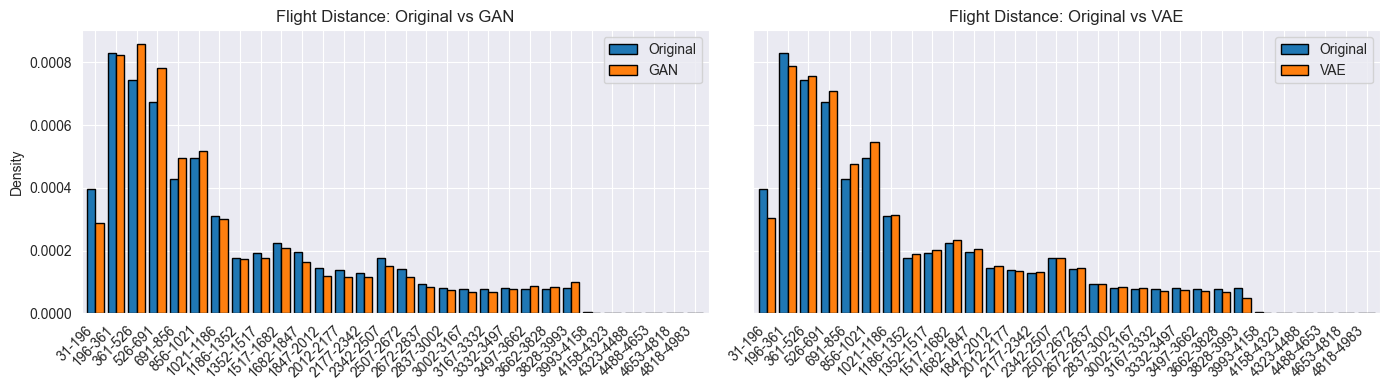

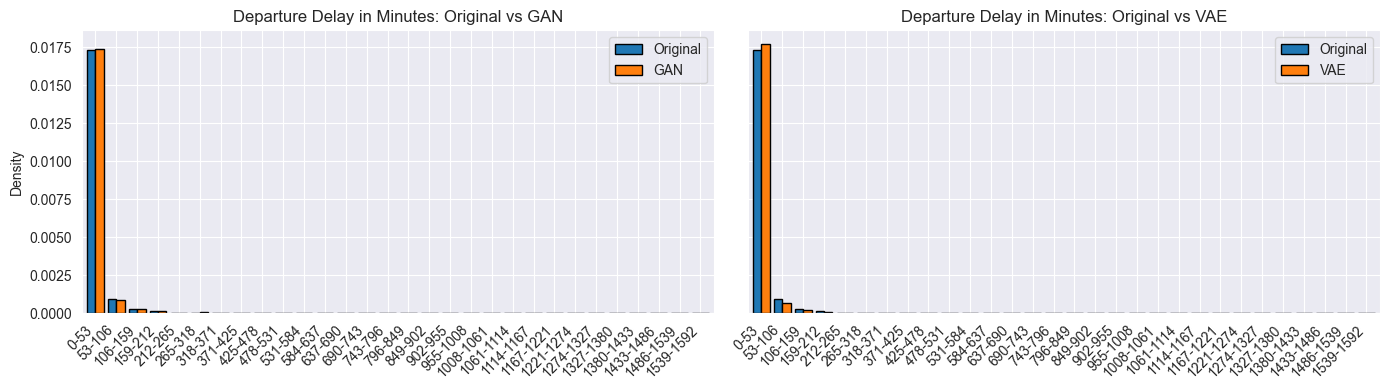

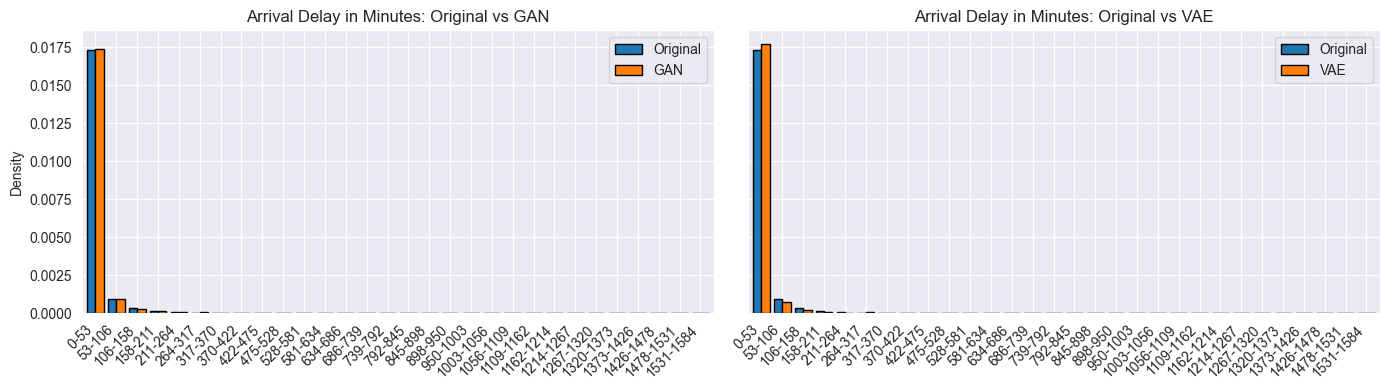

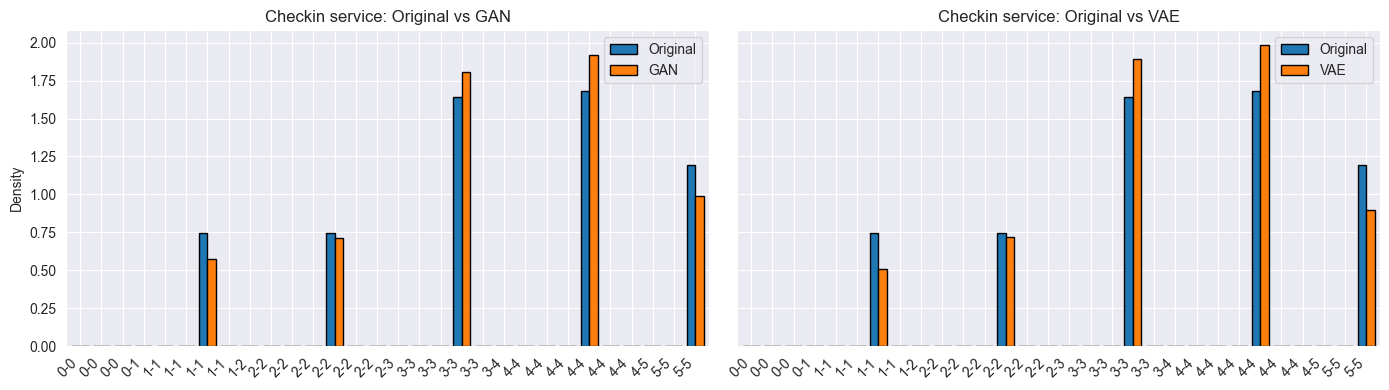

In [182]:
for col in [
    "Age",
    "Flight Distance",
    "Departure Delay in Minutes",
    "Arrival Delay in Minutes",
    "Checkin service",
]:
    orig_vals = airline_dataset[col].dropna().values
    gan_vals = airline_gan_dataset[col].dropna().values
    vae_vals = airline_vae_dataset[col].dropna().values

    # Define common bins based on original data
    bins = np.histogram_bin_edges(orig_vals, bins=30)

    # Compute a normalized histogram (density) for each dataset
    orig_counts, _ = np.histogram(orig_vals, bins=bins, density=True)
    gan_counts, _ = np.histogram(gan_vals, bins=bins, density=True)
    vae_counts, _ = np.histogram(vae_vals, bins=bins, density=True)

    # Create bin labels
    bin_labels = [f"{bins[i]:.0f}-{bins[i+1]:.0f}" for i in range(len(bins) - 1)]

    # Build DataFrames for plotting
    df_og = pd.DataFrame({"Original": orig_counts, "GAN": gan_counts}, index=bin_labels)
    df_ov = pd.DataFrame({"Original": orig_counts, "VAE": vae_counts}, index=bin_labels)

    # Plot side-by-side bar charts
    fig, axes = plt.subplots(1, 2, figsize=(14, 4), sharey=True)

    df_og.plot(kind="bar", ax=axes[0], width=0.8, edgecolor="black")
    axes[0].set_title(f"{col}: Original vs GAN")
    axes[0].set_ylabel("Density")

    df_ov.plot(kind="bar", ax=axes[1], width=0.8, edgecolor="black")
    axes[1].set_title(f"{col}: Original vs VAE")

    for ax in axes:
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
        ax.legend()
    plt.tight_layout()
    plt.show()

##### Distributions comparison of categorical columns

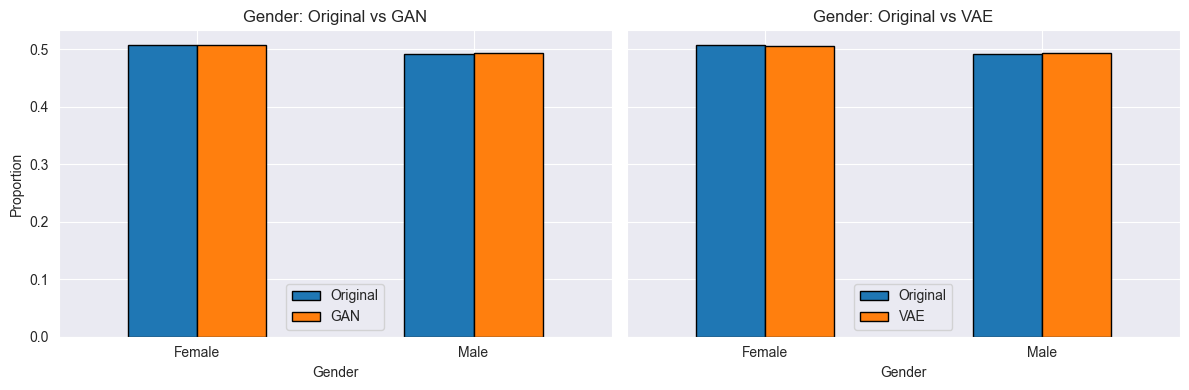

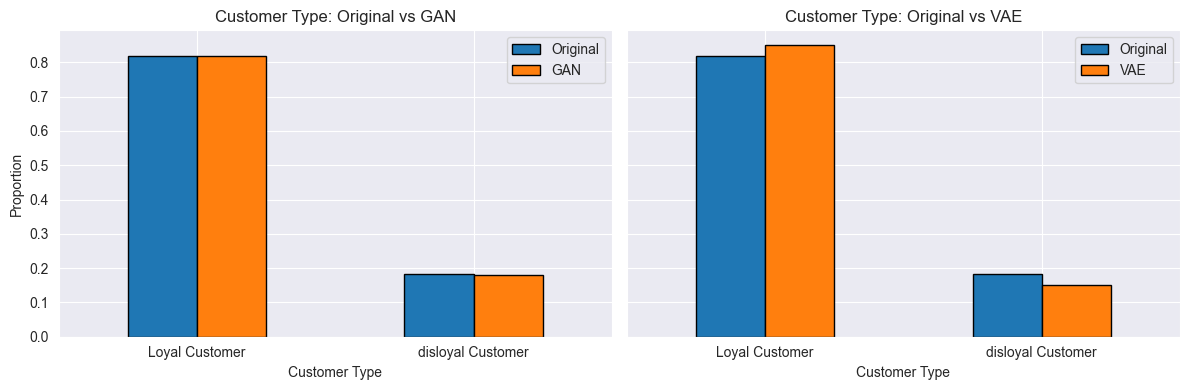

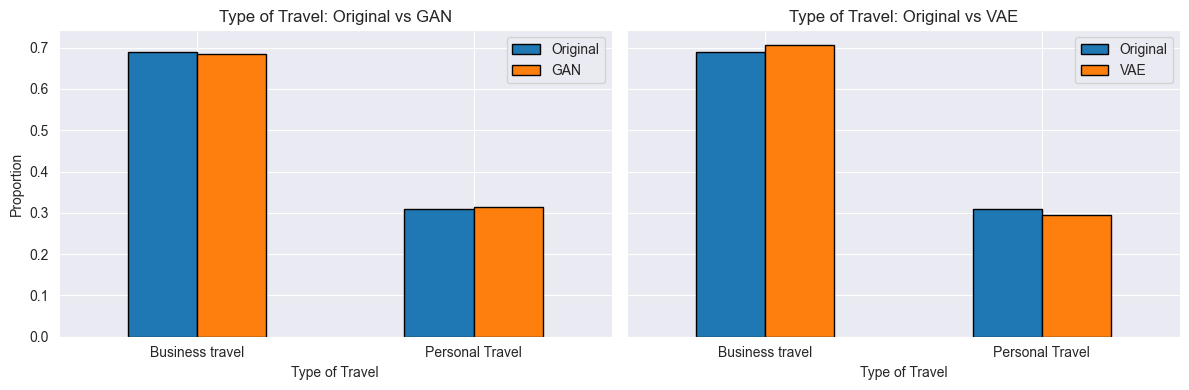

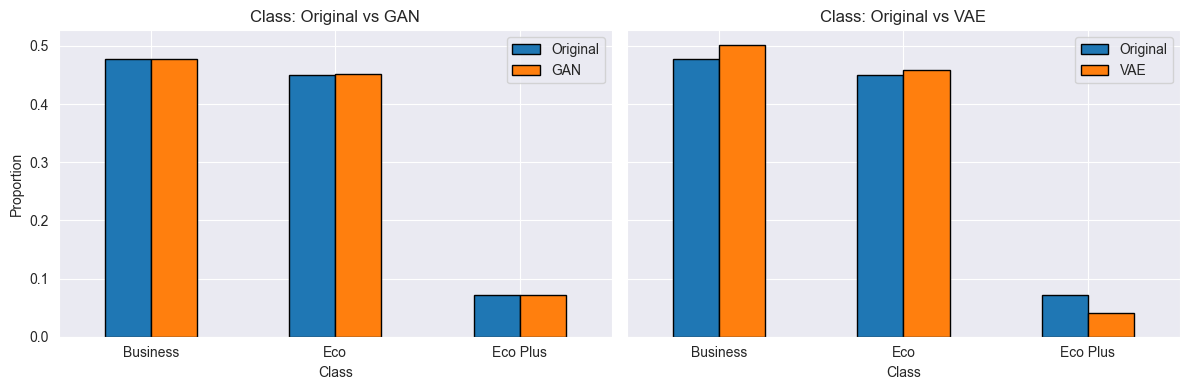

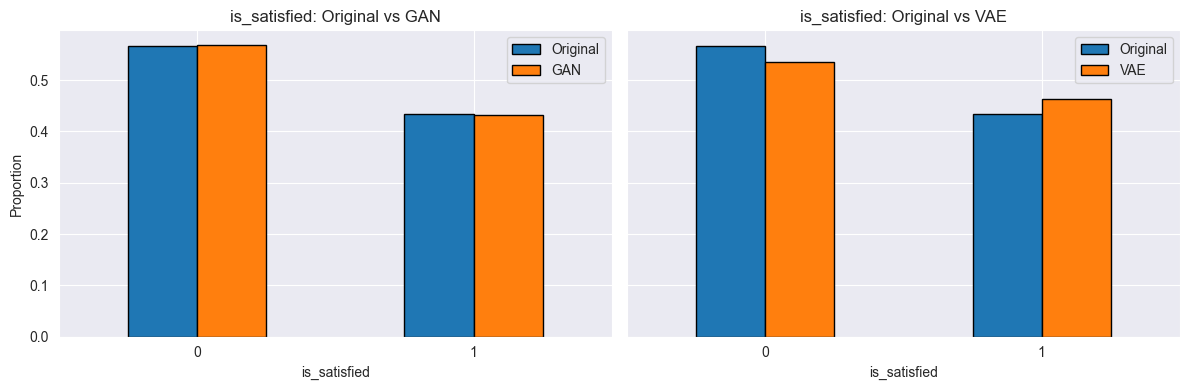

In [183]:
for col in airline_cat_cols:
    # Prepare normalized proportions as strings to avoid mixed-type ordering issues
    orig = (
        airline_dataset[col]
        .fillna("NaN")
        .astype(str)
        .value_counts(normalize=True)
        .sort_index()
    )
    gan = (
        airline_gan_dataset[col]
        .fillna("NaN")
        .astype(str)
        .value_counts(normalize=True)
        .reindex(orig.index, fill_value=0)
    )
    vae = (
        airline_vae_dataset[col]
        .fillna("NaN")
        .astype(str)
        .value_counts(normalize=True)
        .reindex(orig.index, fill_value=0)
    )

    # Build DataFrames for side-by-side bar plots
    df_gan_counts = pd.DataFrame({"Original": orig, "GAN": gan})
    df_vae_counts = pd.DataFrame({"Original": orig, "VAE": vae})

    # Create 1×2 subplot
    fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

    # Plot Original vs GAN
    df_gan_counts.plot(kind="bar", ax=axes[0], edgecolor="black")
    axes[0].set_title(f"{col}: Original vs GAN")
    axes[0].set_ylabel("Proportion")

    # Plot Original vs VAE
    df_vae_counts.plot(kind="bar", ax=axes[1], edgecolor="black")
    axes[1].set_title(f"{col}: Original vs VAE")

    # Tidy up tick labels
    for ax in axes:
        ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
        ax.legend()

    plt.tight_layout()
    plt.show()

##### Distributions comparison of datetime columns

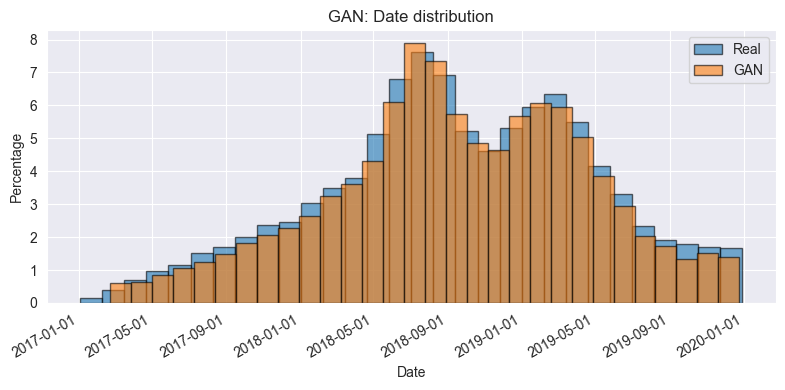

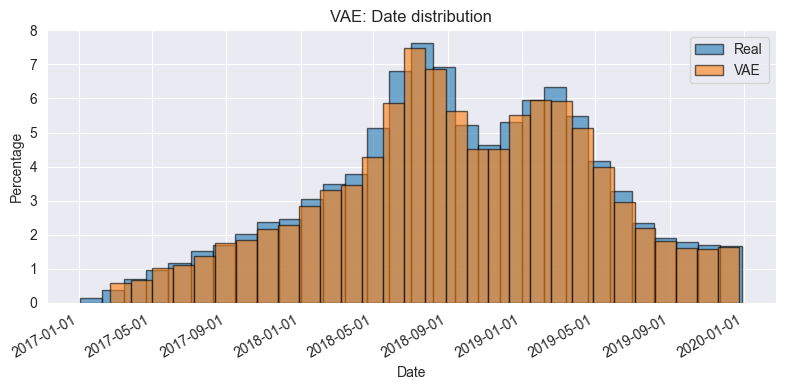

In [184]:
pairs = {
    "GAN": airline_gan_dataset,
    "VAE": airline_vae_dataset,
}

for method, synth_df in pairs.items():
    # prepare both dataframes
    dfs = {"Real": airline_dataset.copy(), method: synth_df.copy()}
    for name, df in dfs.items():
        df["Date"] = pd.to_datetime(df["Date"], format="%Y-%m-%d", errors="coerce")
        dfs[name] = df

    fig, ax = plt.subplots(figsize=(8, 4))
    for name, df in dfs.items():
        dates = df["Date"].dropna()
        # convert to matplotlib float dates
        x = mdates.date2num(dates)
        # weights so that the sum of bar heights = 100%
        weights = np.ones_like(x) / len(x) * 100
        ax.hist(x, bins=30, weights=weights, alpha=0.6, label=name, edgecolor="black")

    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
    fig.autofmt_xdate(rotation=30)
    ax.set_title(f"{method}: Date distribution")
    ax.set_xlabel("Date")
    ax.set_ylabel("Percentage")
    ax.legend()
    plt.tight_layout()
    plt.show()

#### Correlation matrixes

##### Utility methods for correlation matrixes (Pearson, eta correlation ratio, Cramer's V)

In [173]:
def correlation_num_to_num_matrix_plot(df1, df2, columns, title_prefix=""):
    """
    Plots numeric-numeric correlations for Real vs Synthetic and their absolute difference.
    """
    corr_orig = df1[columns].corr()
    corr_gan = df2[columns].corr()
    diff_gan = (corr_orig - corr_gan).abs()

    # 2) Original heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(corr_orig, vmin=-1, vmax=1, cmap="vlag", annot=False, fmt=".2f")
    plt.title("Numeric-Numeric Correlation — Original")
    plt.tight_layout()
    plt.show()

    # 3) GAN heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(corr_gan, vmin=-1, vmax=1, cmap="vlag", annot=False, fmt=".2f")
    plt.title(f"Numeric-Numeric Correlation — {title_prefix}")
    plt.tight_layout()
    plt.show()

    # 4) Absolute-difference heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(diff_gan, vmin=0, vmax=1, cmap="rocket_r", annot=False, fmt=".2f")
    plt.title(f"Absolute Difference |Original – {title_prefix}|")
    plt.tight_layout()
    plt.show()


def correlation_ratio(categories, values):
    df = values.to_frame(name="x").join(categories.rename("g"))
    df = df.dropna(subset=["x", "g"])
    grand_mean = df["x"].mean()
    ss_between = sum(
        grp["x"].count() * (grp["x"].mean() - grand_mean) ** 2
        for _, grp in df.groupby("g")
    )
    ss_total = ((df["x"] - grand_mean) ** 2).sum()
    return ss_between / ss_total if ss_total > 0 else np.nan


def correlation_cat_num_matrix_plot(
    df_real, df_syn, num_cols, cat_cols, title_prefix="", squared=False
):
    def _eta(col_cat, col_num):
        overall = col_num.mean()
        stats = col_num.groupby(col_cat, dropna=False).agg(["count", "mean"])
        ss_between = (stats["count"] * (stats["mean"] - overall) ** 2).sum()
        ss_total = ((col_num - overall) ** 2).sum()
        val = ss_between / ss_total if ss_total > 0 else np.nan
        return val if squared else np.sqrt(val)

    eta_real = pd.DataFrame(index=cat_cols, columns=num_cols, dtype=float)
    eta_syn = pd.DataFrame(index=cat_cols, columns=num_cols, dtype=float)

    for c in cat_cols:
        for n in num_cols:
            eta_real.loc[c, n] = _eta(df_real[c], df_real[n])
            eta_syn.loc[c, n] = _eta(df_syn[c], df_syn[n])

    eta_diff = (eta_real - eta_syn).abs()

    for mat, ttl in zip(
        [eta_real, eta_syn, eta_diff],
        [
            "n Real" if not squared else "n2 Real",
            "n Synthetic" if not squared else "n2 Synthetic",
            "Abs diff",
        ],
    ):
        fig, ax = plt.subplots(figsize=(1.5 * len(num_cols), 0.5 * len(cat_cols) + 3))
        sns.heatmap(
            mat,
            mask=mat.isna(),
            annot=True,
            fmt=".2f",
            xticklabels=num_cols,
            yticklabels=cat_cols,
            cmap="rocket_r",
            vmin=0,
            vmax=1,
            cbar_kws={"label": "η" if not squared else "η²"},
            ax=ax,
        )
        ax.set_title(f"{ttl} ({title_prefix})")
        plt.tight_layout()
        plt.show()


def cramers_v(contingency: np.ndarray, bias_correction: bool = True) -> float:
    """
    Compute Cramer's V statistic for an r-c contingency table.
    If bias_correction=True applies the correction of Bergsma
    """
    chi2, _, _, _ = chi2_contingency(contingency, correction=False)
    n = contingency.sum()
    phi2 = chi2 / n

    r, k = contingency.shape
    # optional bias correction
    if bias_correction:
        phi2_corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
        r_corr = r - ((r - 1) ** 2) / (n - 1)
        k_corr = k - ((k - 1) ** 2) / (n - 1)
        return np.sqrt(phi2_corr / min((k_corr - 1), (r_corr - 1)))
    else:
        return np.sqrt(phi2 / (min(r - 1, k - 1)))


def correlation_cat_cat_matrix_plot(
    df_real: pd.DataFrame,
    df_syn: pd.DataFrame,
    cat_cols: list[str],
    title_prefix: str = "",
    bias_correction: bool = True,
):
    """
    Plots categorical-categorical association (Cramers V) matrices for
    real vs synthetic data and their absolute difference.
    """
    # prepare empty DataFrames
    V_real = pd.DataFrame(index=cat_cols, columns=cat_cols, dtype=float)
    V_syn = pd.DataFrame(index=cat_cols, columns=cat_cols, dtype=float)

    for i, ci in enumerate(cat_cols):
        for j, cj in enumerate(cat_cols):
            # cross‐tabulate and compute Cramer's V
            cont_real = pd.crosstab(df_real[ci], df_real[cj]).values
            cont_syn = pd.crosstab(df_syn[ci], df_syn[cj]).values

            V_real.iloc[i, j] = cramers_v(cont_real, bias_correction)
            V_syn.iloc[i, j] = cramers_v(cont_syn, bias_correction)

    V_diff = (V_real - V_syn).abs()

    # Plotting helper
    def _plot_heatmap(mat, title, cmap="rocket_r", vmin=0, vmax=1):
        plt.figure(figsize=(1.2 * len(cat_cols), 1.2 * len(cat_cols)))
        sns.heatmap(
            mat,
            annot=True,
            fmt=".2f",
            cmap=cmap,
            vmin=vmin,
            vmax=vmax,
            xticklabels=cat_cols,
            yticklabels=cat_cols,
            square=True,
            cbar_kws={"label": "Cramers V"},
        )
        plt.title(title)
        plt.tight_layout()
        plt.show()

    _plot_heatmap(V_real, f"Cramers V — Original")
    _plot_heatmap(V_syn, f"Cramers V — {title_prefix or 'Synthetic'}")
    _plot_heatmap(
        V_diff,
        f"Abs Diff |Original − {title_prefix or 'Synthetic'}|",
        cmap="vlag",
        vmin=0,
        vmax=V_diff.max().max(),
    )

##### Correlation matrixes - numeric to numeric (Pearson)

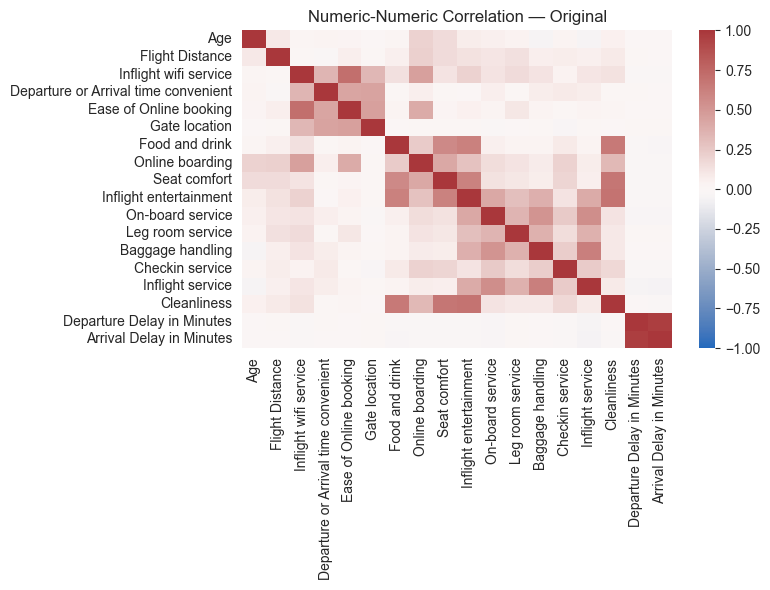

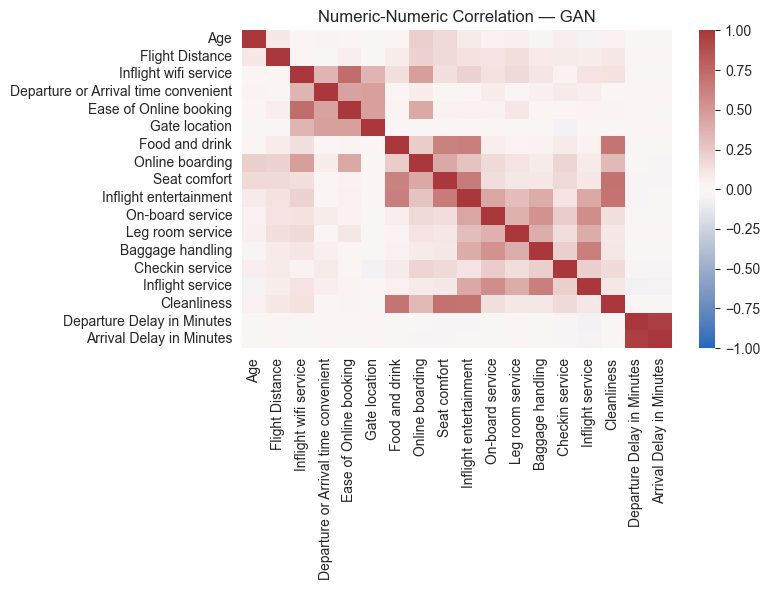

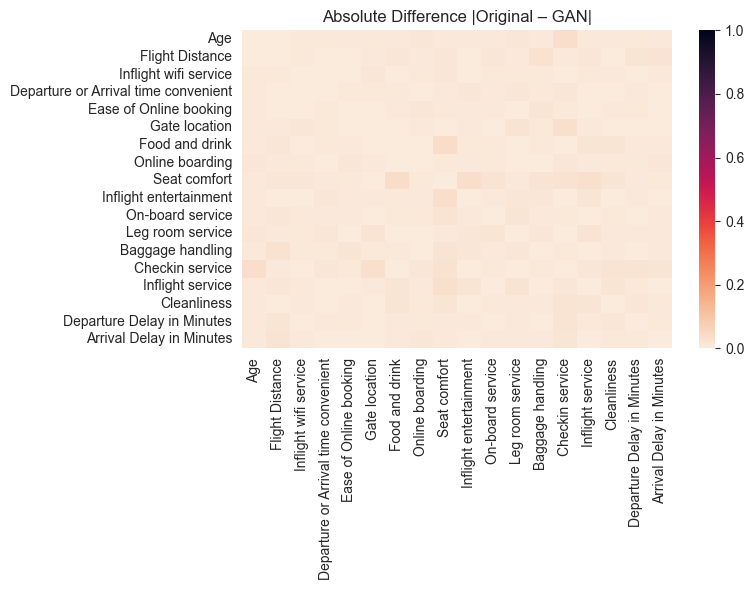

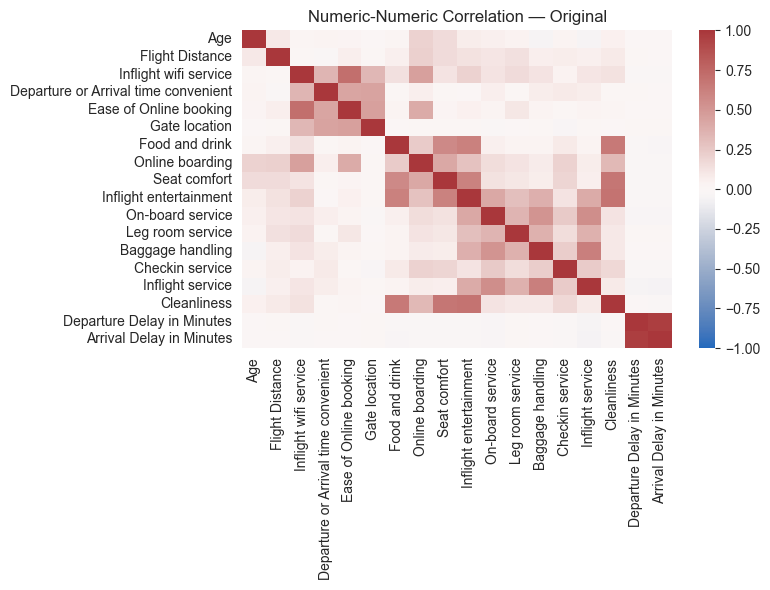

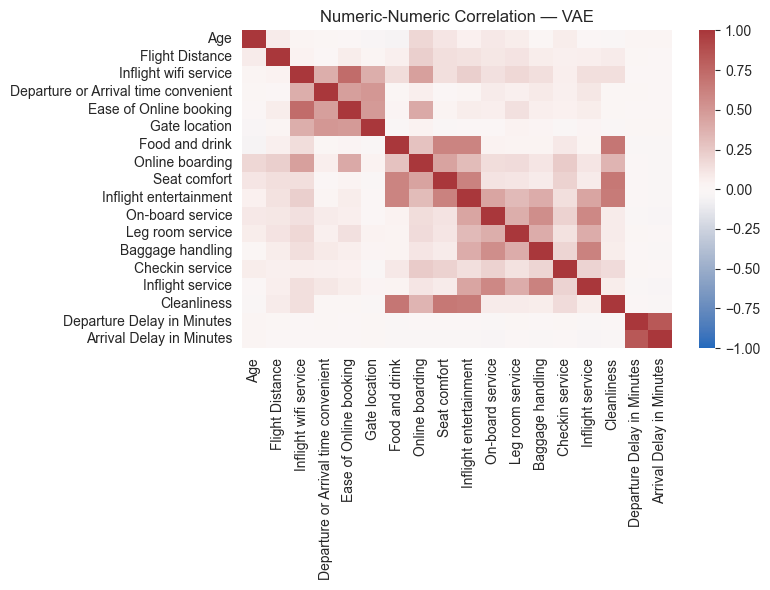

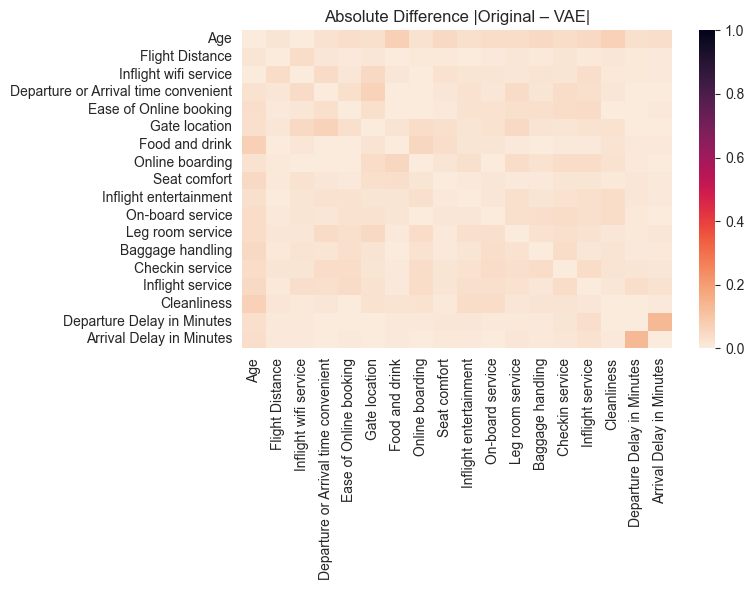

In [185]:
correlation_num_to_num_matrix_plot(
    airline_dataset, airline_gan_dataset, airline_num_cols, "GAN"
)
correlation_num_to_num_matrix_plot(
    airline_dataset, airline_vae_dataset, airline_num_cols, "VAE"
)

##### Correlation matrixes - categoric to numeric (eta)

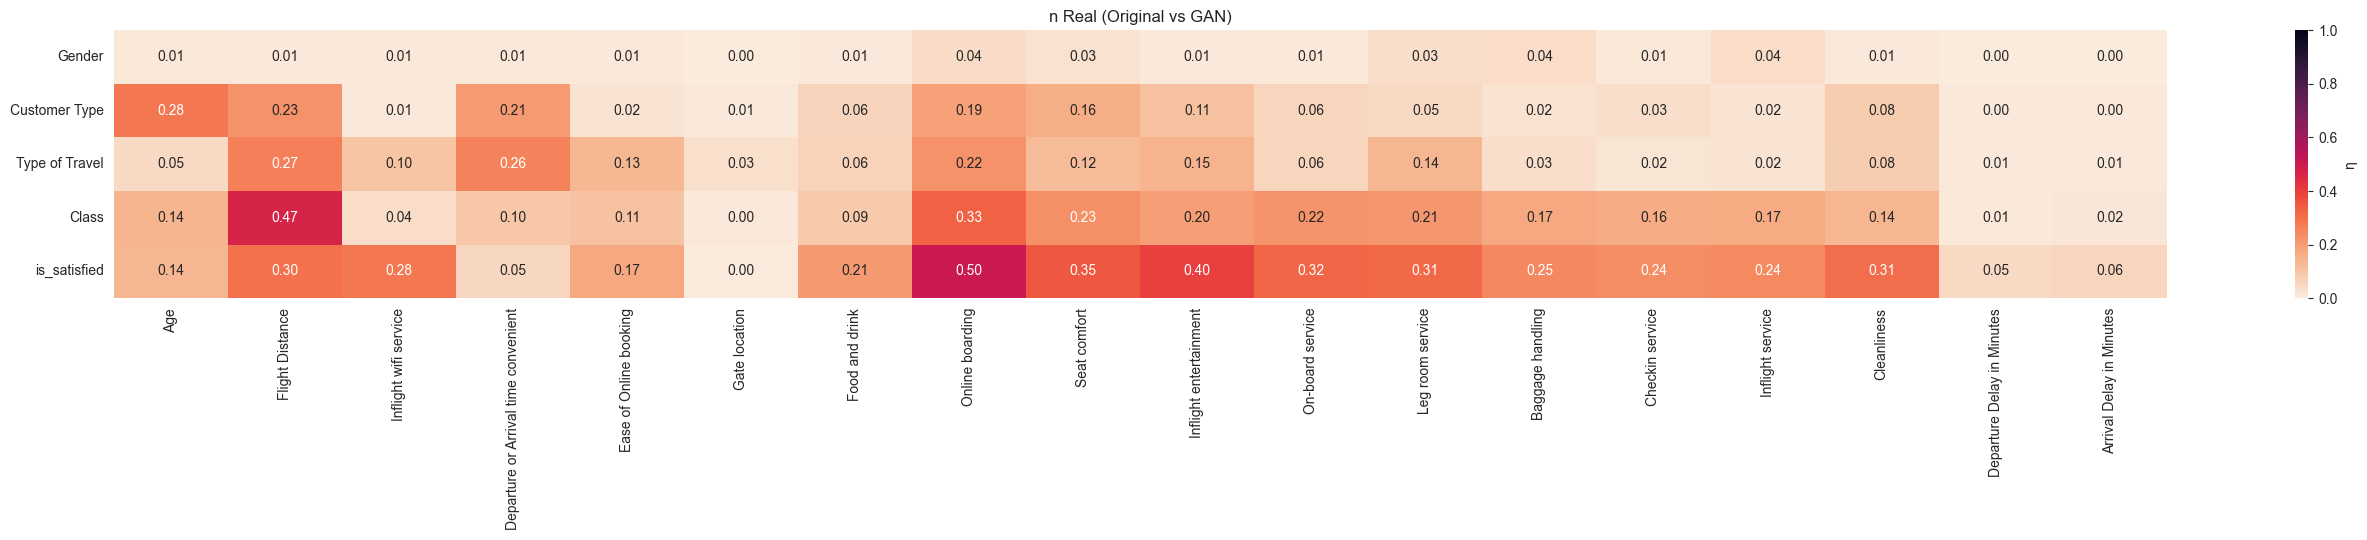

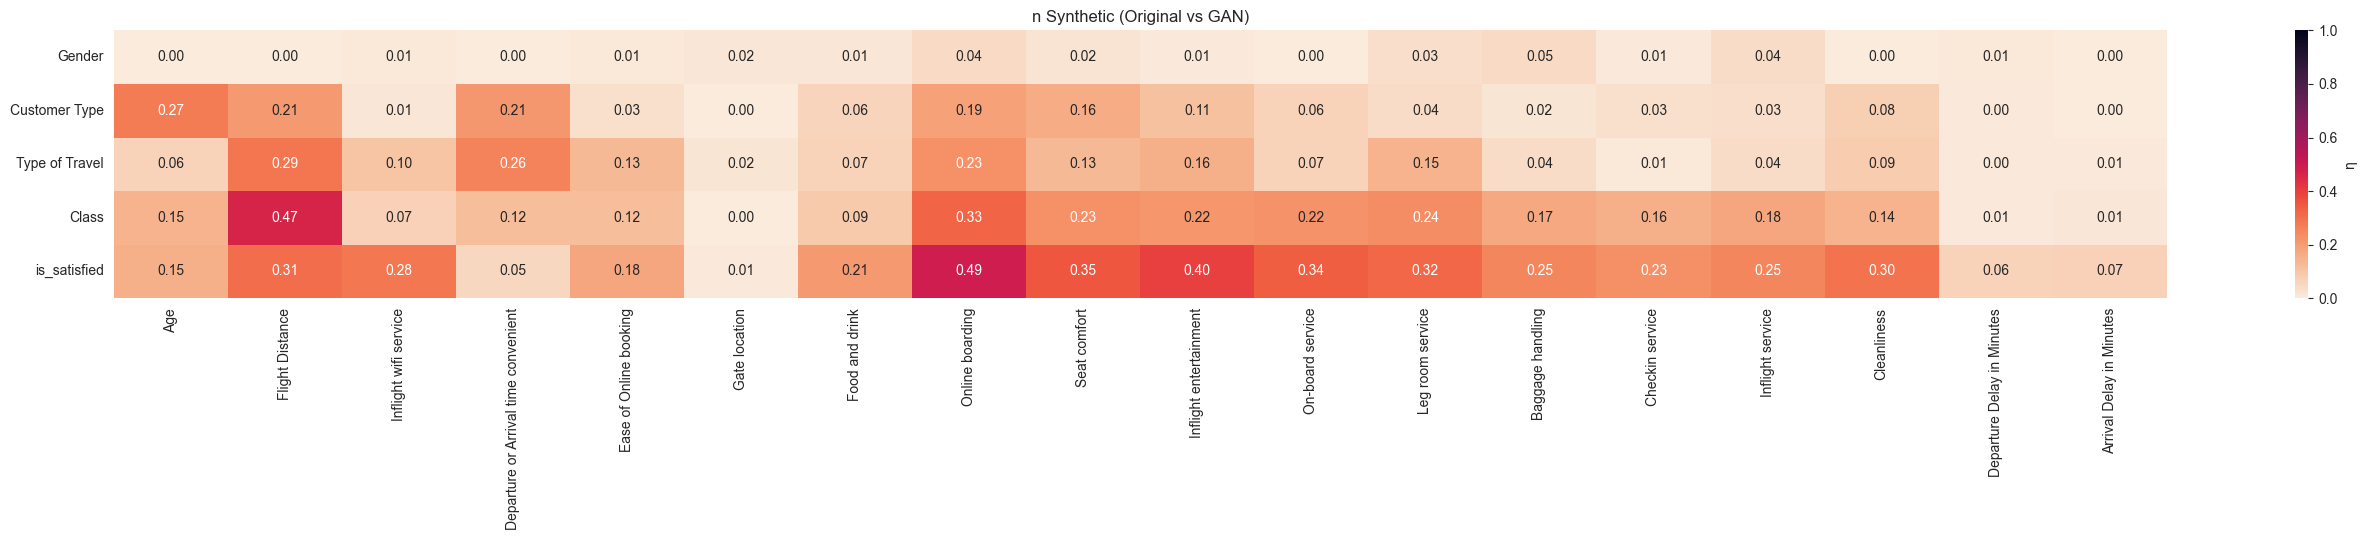

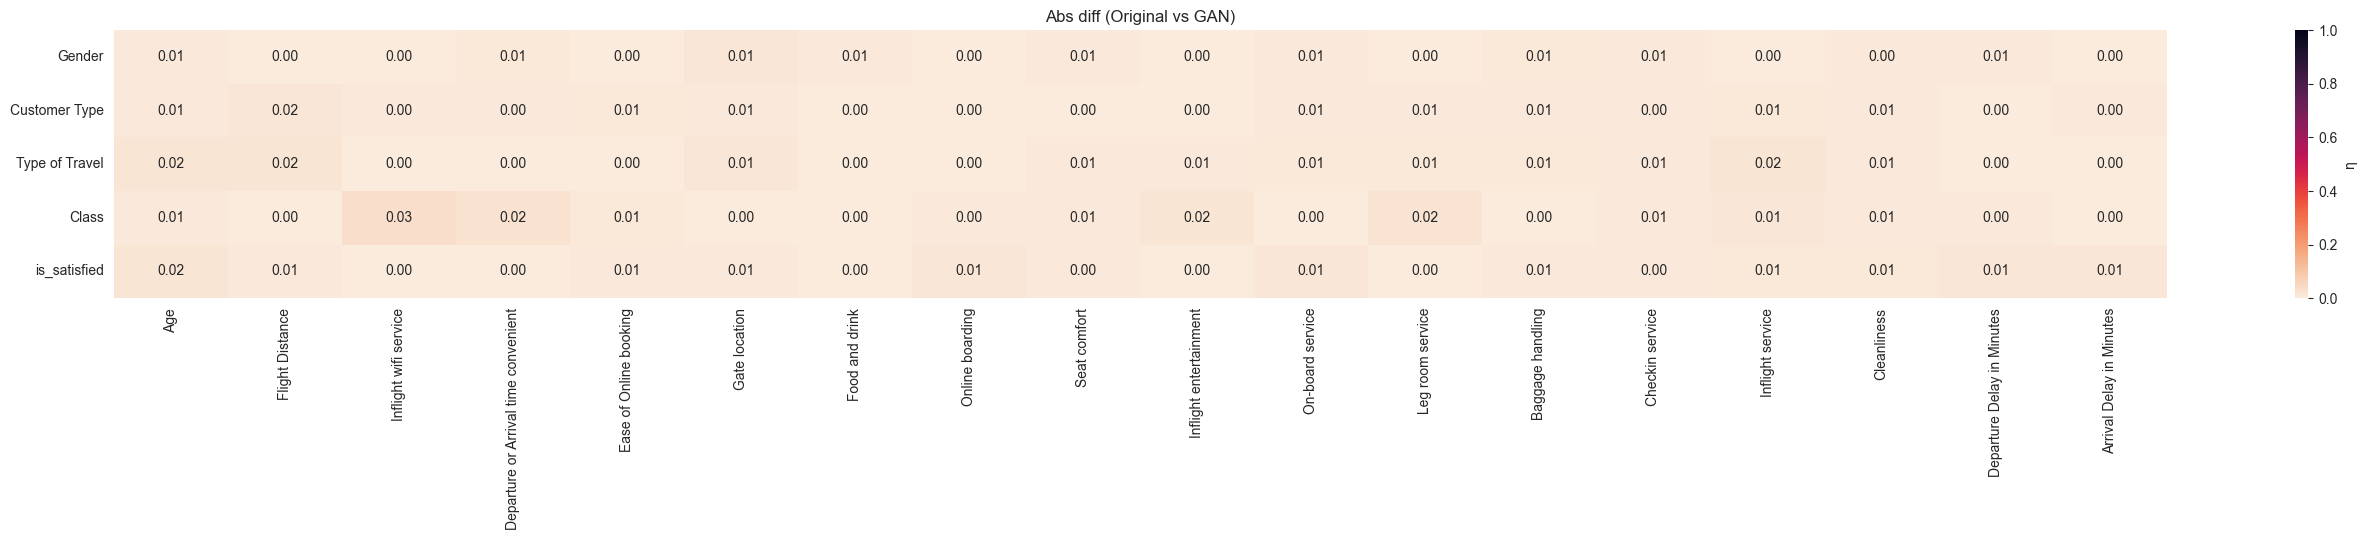

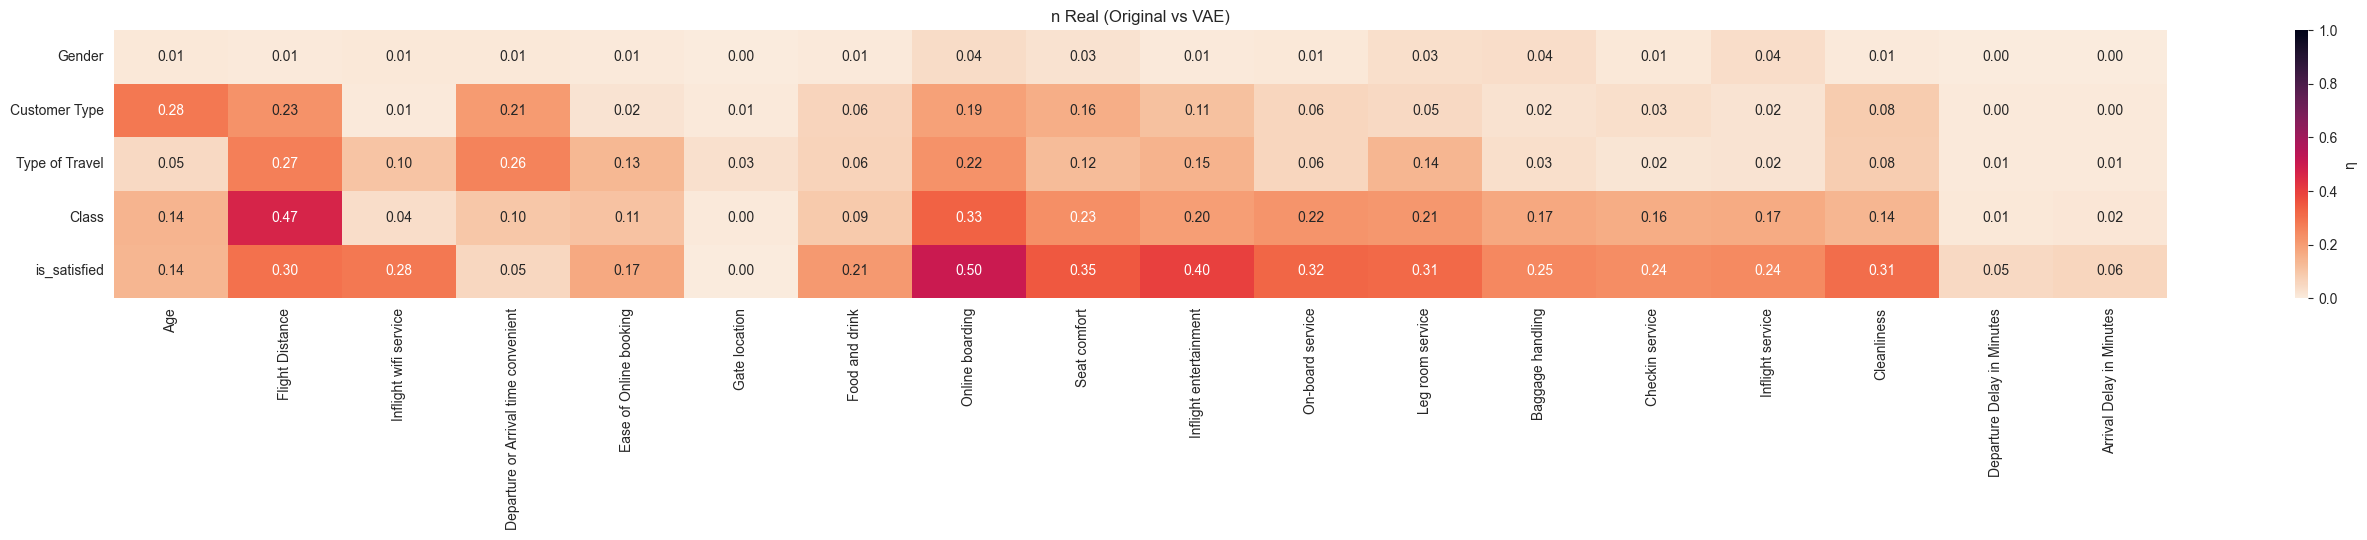

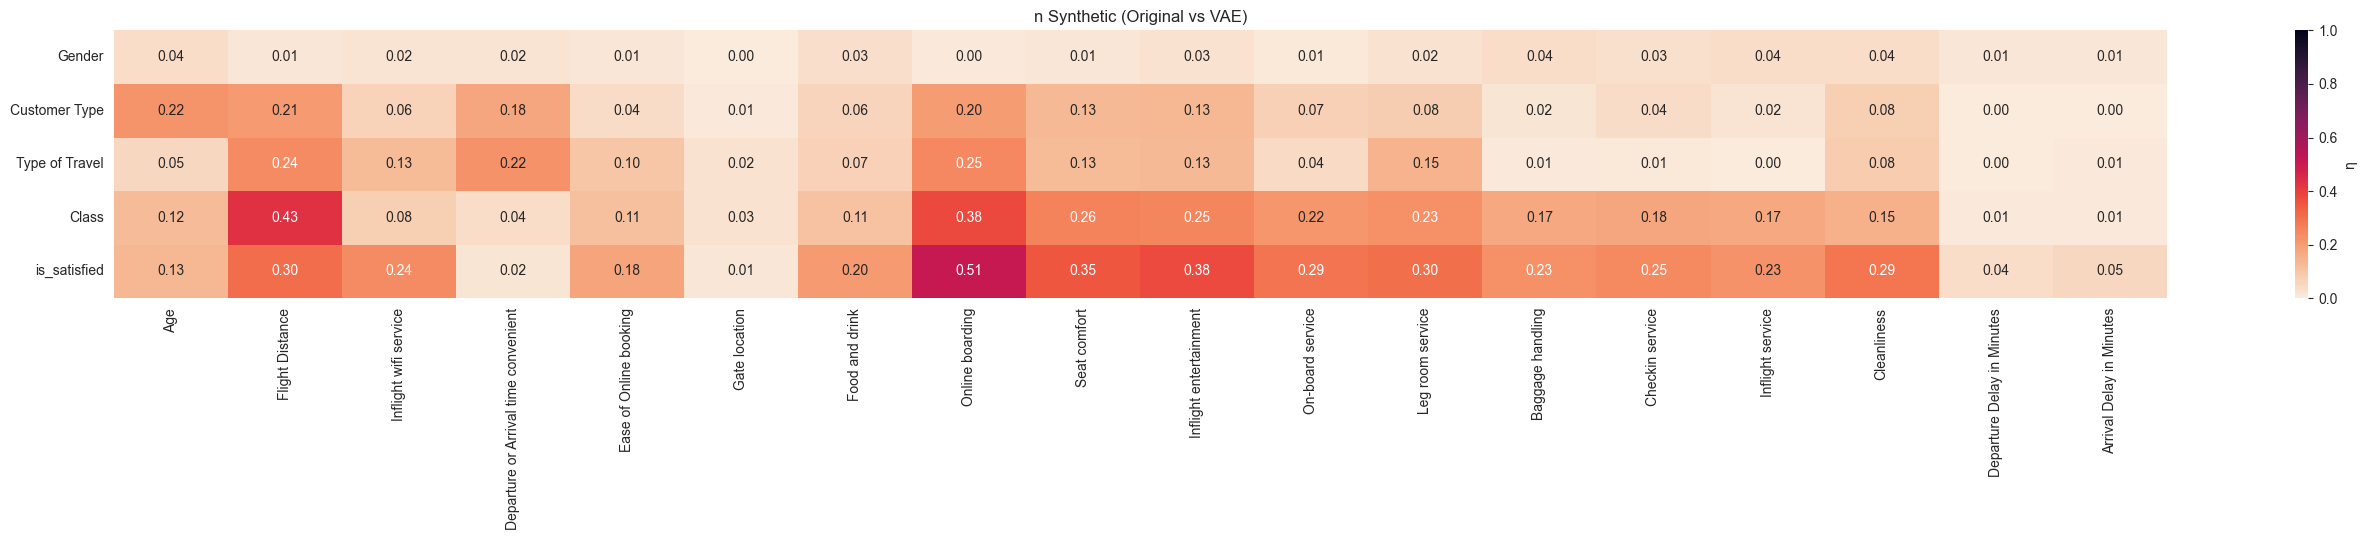

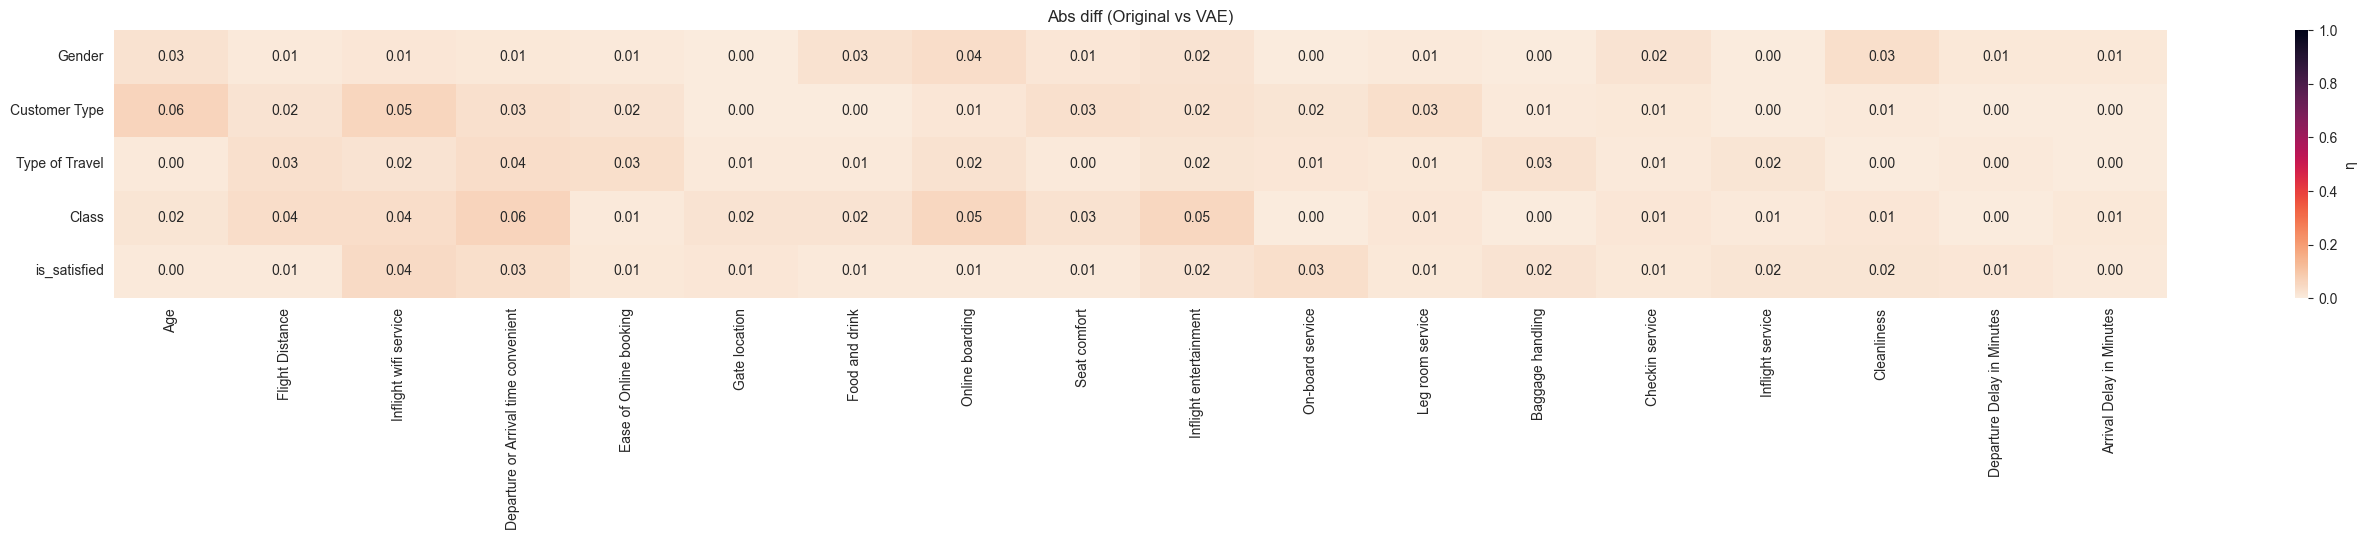

In [186]:
correlation_cat_num_matrix_plot(
    airline_dataset,
    airline_gan_dataset,
    airline_num_cols,
    airline_cat_cols,
    "Original vs GAN",
)
correlation_cat_num_matrix_plot(
    airline_dataset,
    airline_vae_dataset,
    airline_num_cols,
    airline_cat_cols,
    "Original vs VAE",
)

##### Correlation matrixes - categorical to categorical (Cramer's V)

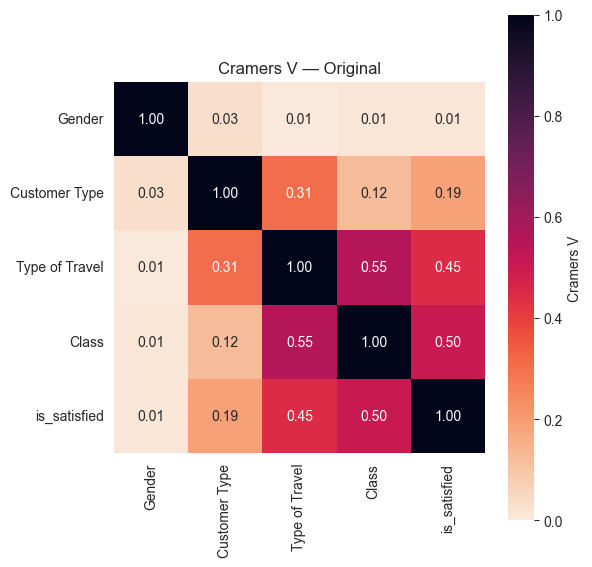

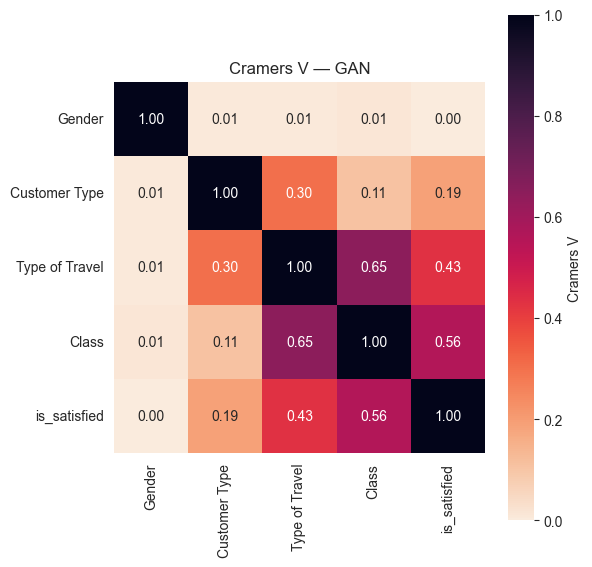

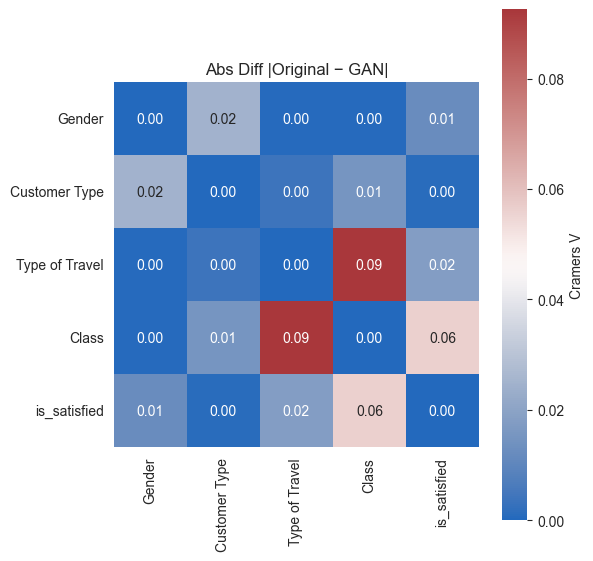

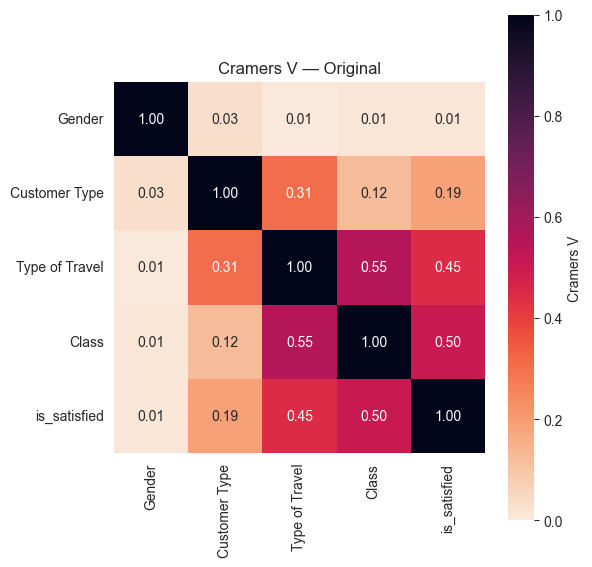

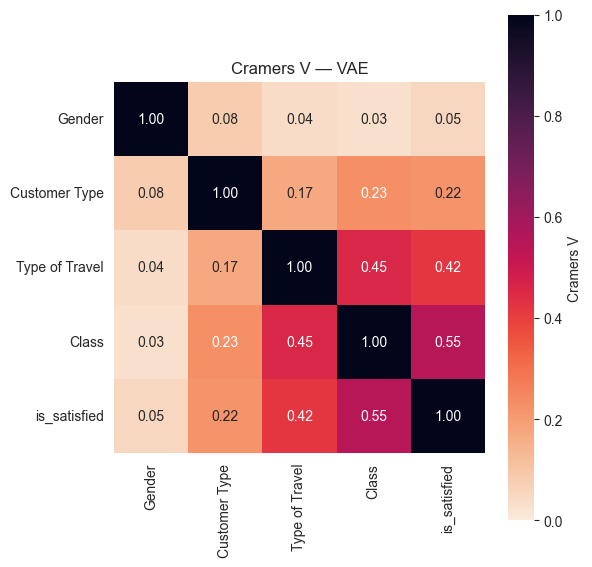

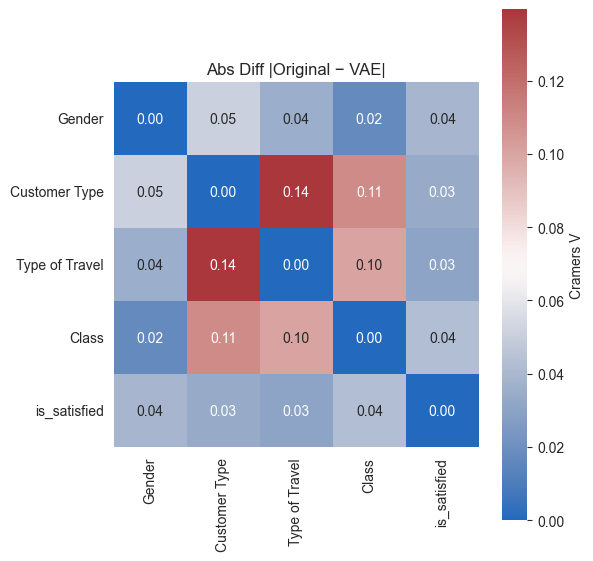

In [187]:
correlation_cat_cat_matrix_plot(
    airline_dataset, airline_gan_dataset, airline_cat_cols, "GAN"
)
correlation_cat_cat_matrix_plot(
    airline_dataset, airline_vae_dataset, airline_cat_cols, "VAE"
)

#### PCA plot

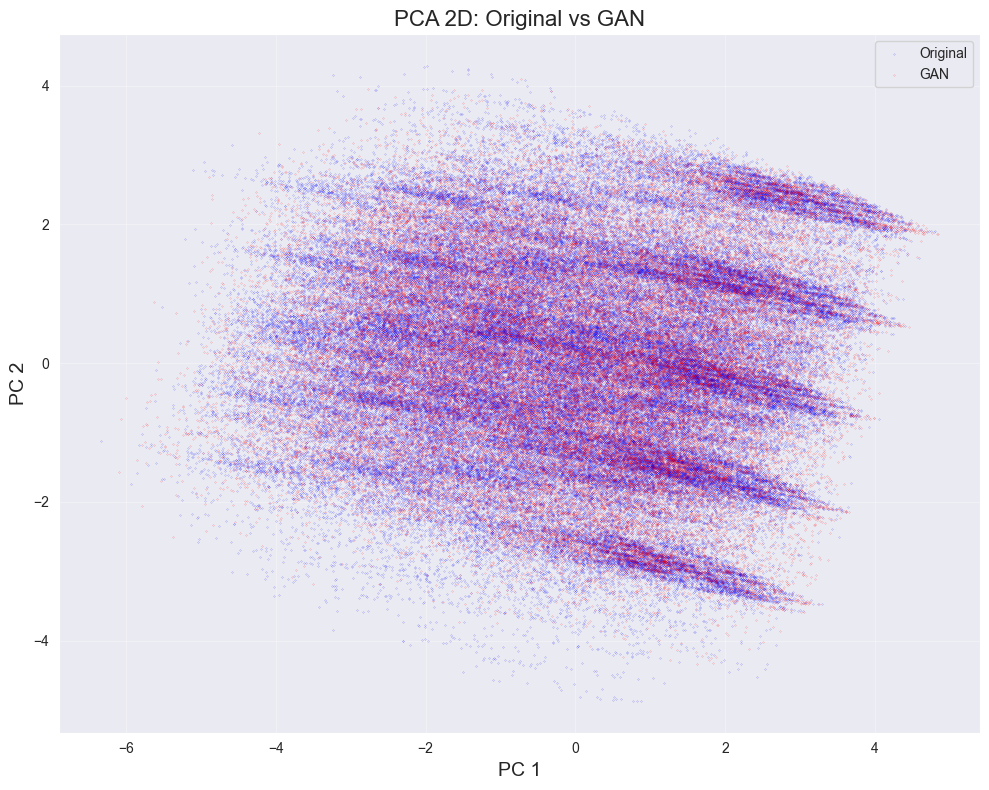

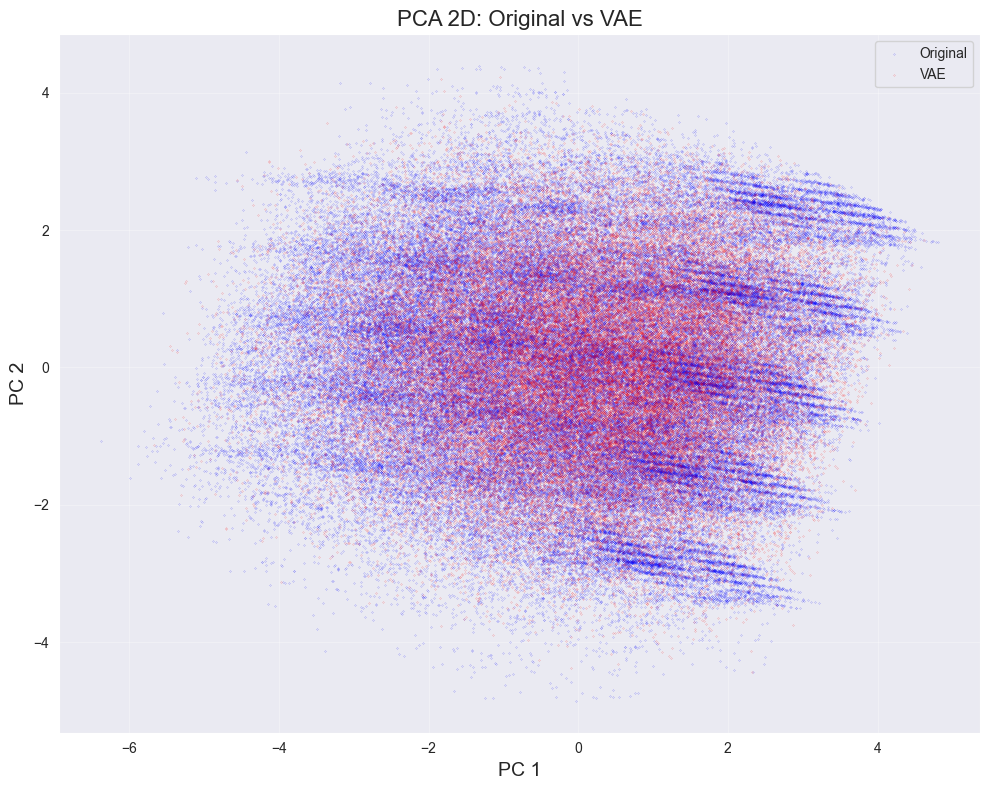

In [126]:
# Standardize original data once
X_orig = StandardScaler().fit_transform(airline_dataset[airline_num_cols].fillna(0))

# Prepare synthetic arrays (scaled with the same scaler for comparability)
scaler = StandardScaler().fit(airline_dataset[airline_num_cols].fillna(0))
X_gan = scaler.transform(airline_gan_dataset[airline_num_cols].fillna(0))
X_vae = scaler.transform(airline_vae_dataset[airline_num_cols].fillna(0))


# Plotting function
def pca_compare(X_other, label):
    X_comb = np.vstack([X_orig, X_other])
    comps = PCA(n_components=2).fit_transform(X_comb)
    n = X_orig.shape[0]
    plt.figure(figsize=(10, 8))
    plt.scatter(comps[:n, 0], comps[:n, 1], s=0.01, c="blue", label="Original")
    plt.scatter(comps[n:, 0], comps[n:, 1], s=0.01, c="red", label=label)
    plt.title(f"PCA 2D: Original vs {label}", fontsize=16)
    plt.xlabel("PC 1", fontsize=14)
    plt.ylabel("PC 2", fontsize=14)
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


# Generate the two plots
pca_compare(X_gan, "GAN")
pca_compare(X_vae, "VAE")

### Discriminator of synthetic data vs original

#### Utility classes/methods for discriminator model

In [154]:
def logistic_discriminator(real_df, synth_df,
                           num_cols, cat_cols,
                           n_components=10,
                           random_state=42):
    # label and split
    real = real_df.copy()
    real["__label"] = 0
    synth = synth_df.copy()
    synth["__label"] = 1
    df = pd.concat([real, synth], ignore_index=True)
    X = df[num_cols + cat_cols]
    y = df["__label"]
    X_tr, X_te, y_tr, y_te = train_test_split(
        X, y, stratify=y, test_size=0.3, random_state=random_state
    )

    # Preprocessing: impute - scale numerics, impute - OHE categoricals
    num_pipe = Pipeline([
        ("impute", SimpleImputer(strategy="mean")),
        ("scale",  StandardScaler())
    ])
    cat_pipe = Pipeline([
        ("impute", SimpleImputer(strategy="constant", fill_value="__miss__")),
        ("ohe",     OneHotEncoder(drop="first", handle_unknown="ignore", sparse_output=False))
    ])
    prep = ColumnTransformer([
        ("num", num_pipe, num_cols),
        ("cat", cat_pipe, cat_cols)
    ], remainder="drop")

    # Full pipeline: prep - PCA - logistic
    pipe = Pipeline([
        ("prep", prep),
        ("pca",  PCA(n_components=n_components, random_state=random_state)),
        ("clf",  LogisticRegression(
                     C=0.1,
                     class_weight="balanced",
                     max_iter=500,
                     random_state=random_state
                 ))
    ])

    # Fit and evaluate
    pipe.fit(X_tr, y_tr)
    probs = pipe.predict_proba(X_te)[:, 1]
    preds = pipe.predict(X_te)

    metrics = {
        "Accuracy": accuracy_score(y_te, preds),
        "ROC AUC":  roc_auc_score(y_te, probs)
    }
    fpr, tpr, _ = roc_curve(y_te, probs)
    cm = confusion_matrix(y_te, preds)

    return metrics, (fpr, tpr), cm

#### Run disriminator on both synthetic datasets and compare results

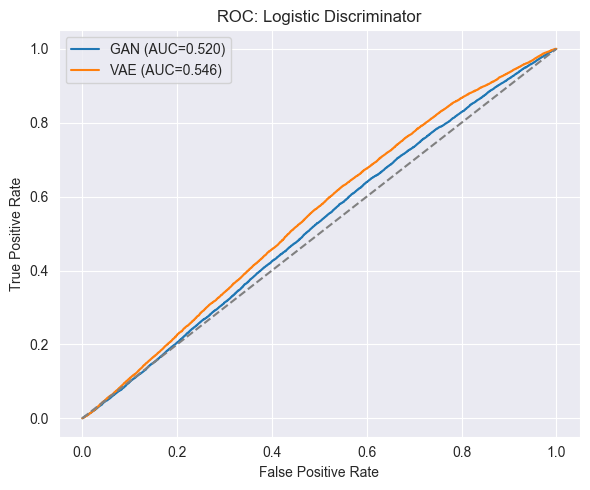

In [156]:
target_col = 'is_satisfied'
cat_cols = [c for c in airline_cat_cols if c != target_col]


results, roc_data, cm_data = {}, {}, {}
for name, synth in [("GAN", airline_gan_dataset), ("VAE", airline_vae_dataset)]:
    m, (fpr, tpr), cm = logistic_discriminator(
        real_df=airline_dataset,
        synth_df=synth,
        num_cols=airline_num_cols,
        cat_cols=cat_cols,
        n_components=10,
        random_state=42
    )
    results[name]   = m
    roc_data[name]  = (fpr, tpr)
    cm_data[name]   = cm

# Display metrics
metrics_df = pd.DataFrame(results).T
display(metrics_df.style.format("{:.3f}")
        .set_caption("Logistic Discriminator: Real vs GAN/VAE"))

# Plot ROC curves
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
for name in roc_data:
    fpr, tpr = roc_data[name]
    ax.plot(fpr, tpr, label=f"{name} (AUC={results[name]['ROC AUC']:.3f})")
ax.plot([0,1],[0,1],"--",color="gray")
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.set_title("ROC: Logistic Discriminator")
ax.legend()
plt.tight_layout()
plt.show()

### Classification if user satisfied with airline services

#### Utility method for augment minority, evaluate

In [110]:
def evaluate(train_X, train_y, test_X, test_y) -> dict[str, float]:
    X_tr = ct.transform(train_X)
    X_te = ct.transform(test_X)
    clf = RandomForestClassifier(
        n_estimators=300,
        max_depth=None,
        max_features=0.3,
        min_samples_leaf=1,
        random_state=42,
    )
    clf.fit(X_tr, train_y)
    preds = clf.predict(X_te)
    probs = clf.predict_proba(X_te)[:, 1]
    return {
        "ROC AUC": roc_auc_score(test_y, probs) * 100,
        "F1 score": f1_score(test_y, preds) * 100,
    }

In [111]:
target_col = "is_satisfied"
cat_cols = [c for c in airline_cat_cols if c != target_col]
# Get feature columns(numeric + categoric + boolean, except target)
feature_cols = [
    c
    for c in airline_dataset.columns
    if c in airline_num_cols + airline_cat_cols and c != target_col
]
# Ensure target column is int type
for df in (airline_dataset, airline_gan_dataset, airline_vae_dataset):
    df[target_col] = df[target_col].astype(int)
# Split data to train and test parts
X = airline_dataset[feature_cols]
y = airline_dataset[target_col]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# Run evaluations
results = {}
results["Real only"] = evaluate(X_train, y_train, X_test, y_test)
#results["Real only"] = {'ROC AUC':98.2364,'F1 score':94.0378}
results["Real + GAN"] = evaluate(
    pd.concat([X_train, airline_gan_dataset[feature_cols]], ignore_index=True),
    pd.concat([y_train, airline_gan_dataset[target_col]], ignore_index=True),
    X_test,
    y_test,
)
results["Real + VAE"] = evaluate(
    pd.concat([X_train, airline_vae_dataset[feature_cols]], ignore_index=True),
    pd.concat([y_train, airline_vae_dataset[target_col]], ignore_index=True),
    X_test,
    y_test,
)

df = pd.DataFrame(results).T
baseline = df.iloc[0]

for metric in df.columns:
    df[f"{metric} % change"] = (df[metric] - baseline[metric]) / baseline[metric] * 100

display(df)

ROC AUC   F1 score  ROC AUC % change  F1 score % change
Real only   98.236400  94.037800          0.000000           0.000000
Real + GAN  99.223823  95.075901          1.005150           1.103918
Real + VAE  99.149709  94.686721          0.929705           0.690064

# Household Power Consumption Dataset

## Preprocessing and data generation

##### Metadata for synthetic generation

In [3]:
household_dataset_metadata = {
    "Date_time": FieldMetadata(
        data_type=DataType.DATETIME, datetime_format="%Y-%m-%d %H:%M:%S"
    ),
    "Global_active_power": FieldMetadata(data_type=DataType.DECIMAL, decimal_places=3),
    "Global_reactive_power": FieldMetadata(
        data_type=DataType.DECIMAL, decimal_places=3
    ),
    "Voltage": FieldMetadata(data_type=DataType.DECIMAL, decimal_places=2),
    "Global_intensity": FieldMetadata(data_type=DataType.DECIMAL, decimal_places=1),
    "Sub_metering_1": FieldMetadata(data_type=DataType.DECIMAL, decimal_places=1),
    "Sub_metering_2": FieldMetadata(data_type=DataType.DECIMAL, decimal_places=1),
    "Sub_metering_3": FieldMetadata(data_type=DataType.DECIMAL, decimal_places=1),
}

In [5]:
household_dataset_num_cols = [
    key
    for key, value in household_dataset_metadata.items()
    if value.data_type in (DataType.DECIMAL, DataType.INTEGER)
]

##### Loading and preprocessing a dataset for training neural networks

In [8]:
def load_household_dataset(csv_path: str):
    # Loading dataset
    raw = pd.read_csv(csv_path, sep=";", dayfirst=True, na_values="?")
    # Parse datetime explicitly to avoid FutureWarning
    raw["Date_time"] = pd.to_datetime(
        raw["Date"].str.strip() + " " + raw["Time"].str.strip(),
        format="%d/%m/%Y %H:%M:%S",
        dayfirst=True,
        errors="coerce",
    )
    # Drop rows where parsing failed
    df_power = raw.dropna(subset=["Date_time"]).drop(columns=["Date", "Time"])

    df_power = df_power.set_index("Date_time").sort_index()
    # Resample to an explicit hourly index
    df_hourly = df_power.resample("h").sum()
    # Interpolate missing hours by time
    df_hourly_interp = df_hourly.interpolate(method="time")
    # interpolate numeric columns
    df_hourly_interp[household_dataset_num_cols] = df_hourly[
        household_dataset_num_cols
    ].interpolate(method="time")
    # form final dataset for training
    return df_hourly_interp.reset_index()


household_dataset = load_household_dataset("datasets/household_power_consumption.csv")
print(f"Rows count in dataset: {household_dataset.shape[0]}")
print(f"Column amount: {household_dataset.shape[1]}")
display(household_dataset.head())

Loaded hourly data shape: (34589, 8)


Date_time  Global_active_power  Global_reactive_power   Voltage  \
0 2006-12-16 17:00:00              152.024                  8.244   8447.18   
1 2006-12-16 18:00:00              217.932                  4.802  14074.81   
2 2006-12-16 19:00:00              204.014                  5.114  13993.95   
3 2006-12-16 20:00:00              196.114                  4.506  14044.29   
4 2006-12-16 21:00:00              183.388                  4.600  14229.52   

   Global_intensity  Sub_metering_1  Sub_metering_2  Sub_metering_3  
0             651.6             0.0            19.0           607.0  
1             936.0             0.0           403.0          1012.0  
2             870.2             0.0            86.0          1001.0  
3             835.0             0.0             0.0          1007.0  
4             782.8             0.0            25.0          1033.0

##### Data generation using GAN and VAE neural networks

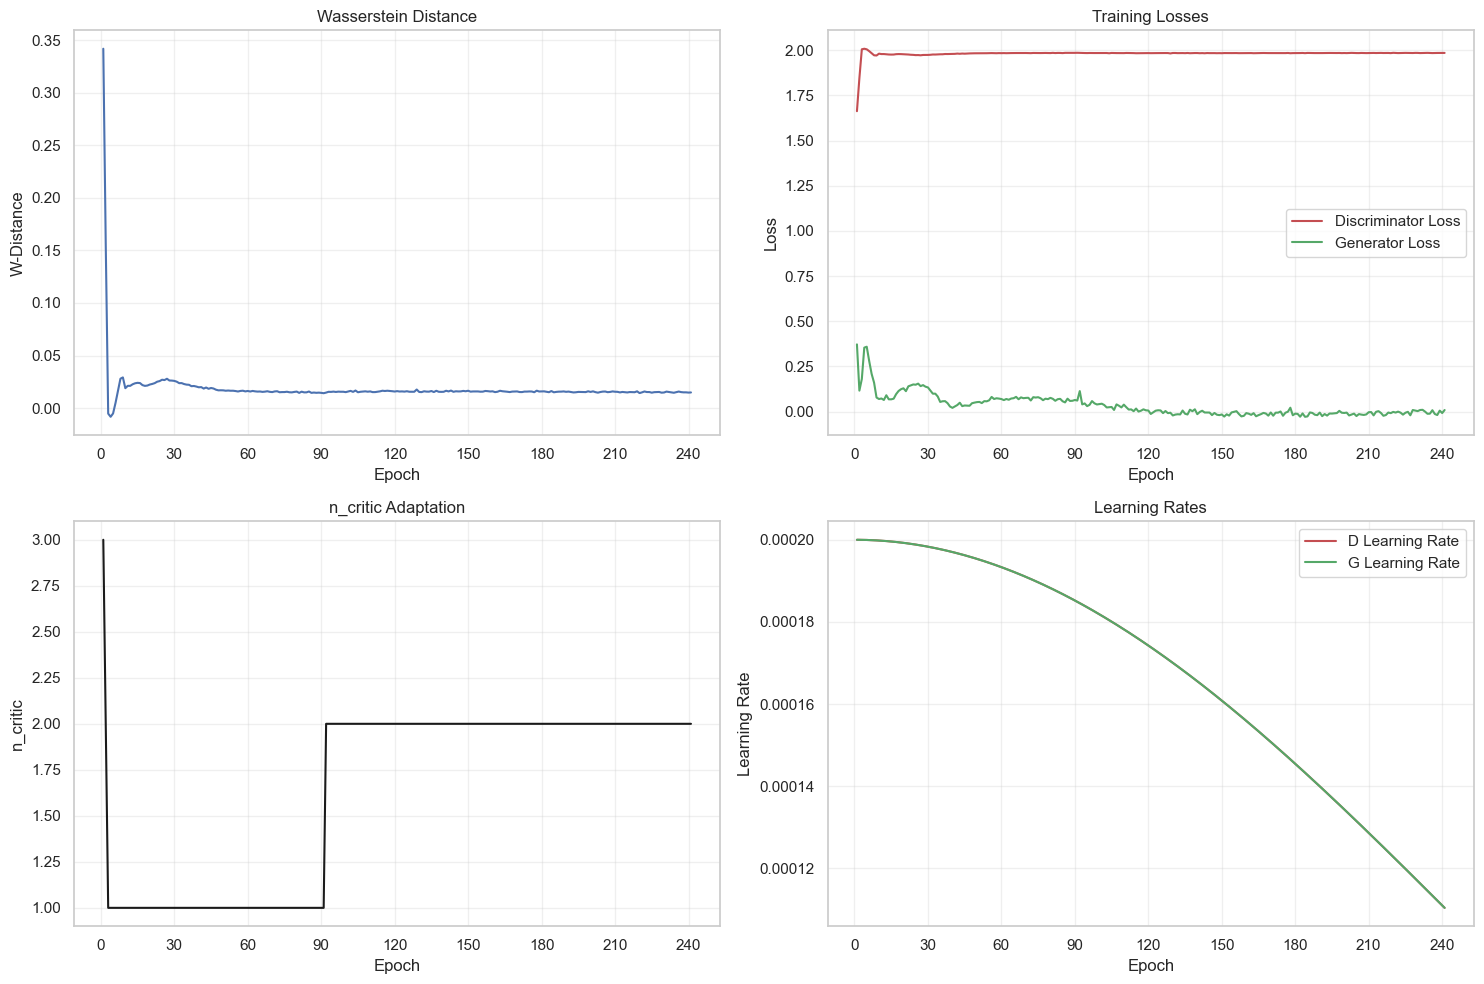

In [9]:
cfg = GanConfig(
    epochs=500,
    patience=240,
    g_lr=2e-4,
    d_lr=2e-4,
    use_hinge=True,
    use_fm_loss=True,
    fm_w=10.0,
    use_cov_loss=True,
    cov_w=2.0,
    use_delta_loss=True,
    delta_w=5.0,
    use_bias_correction=True,
)
gan_full = GAN(household_dataset, household_dataset_metadata, cfg)
gan_full.fit(verbose=True)
S_gan_full = gan_full.generate(len(household_dataset), temperature=0.7)

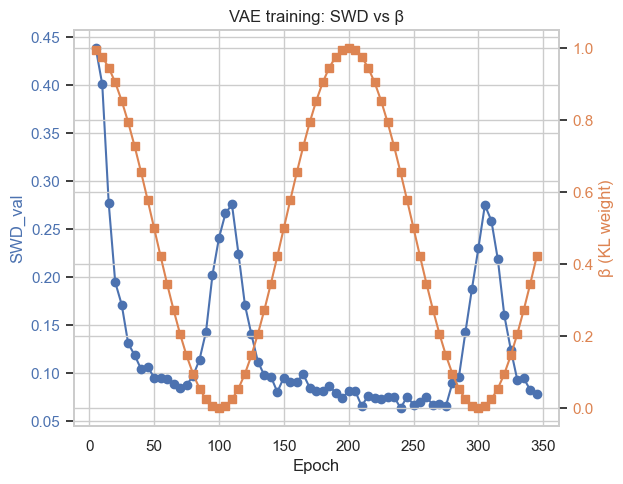

In [10]:
vae_full = VAE(household_dataset, household_dataset_metadata)
vae_full.fit(epochs=400, verbose=True)
S_vae_full = vae_full.generate(len(household_dataset))

##### Statistical analysis of synthetic data

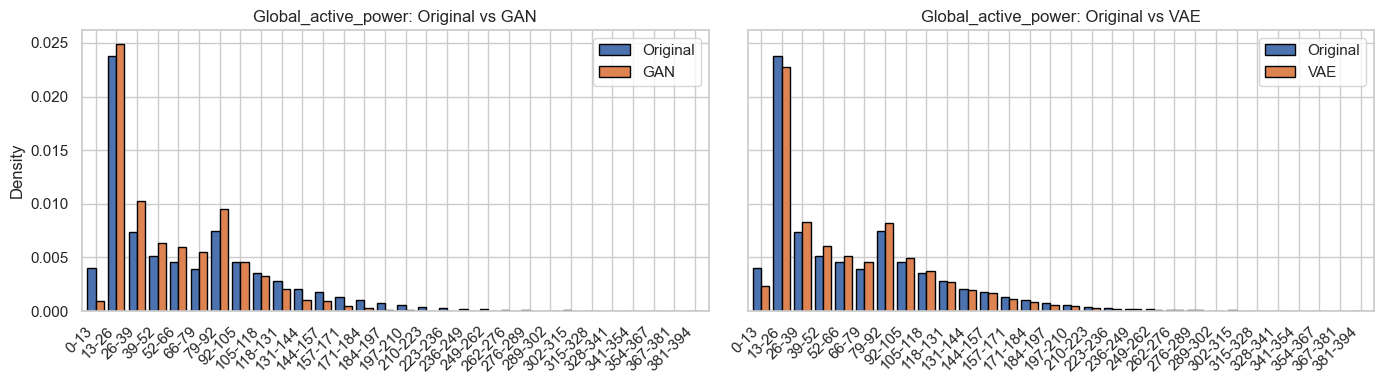

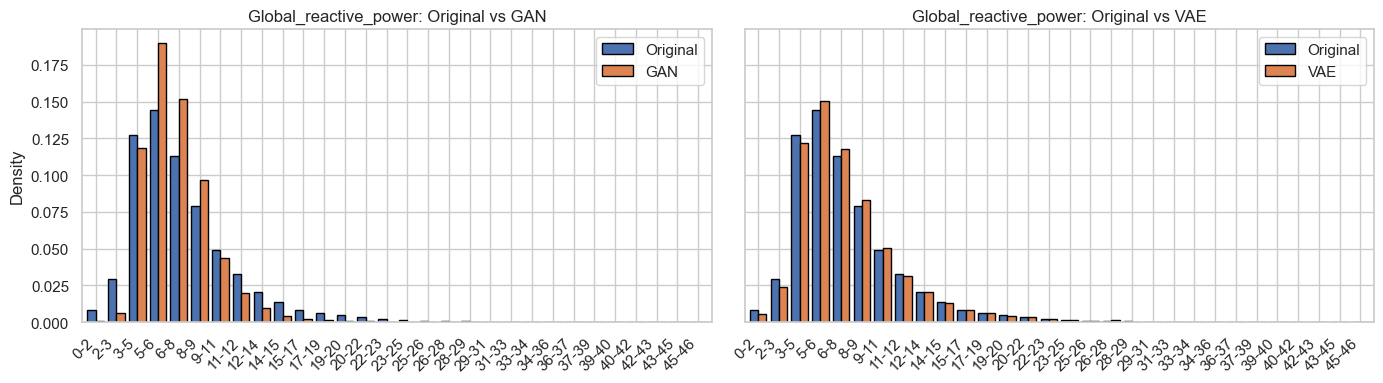

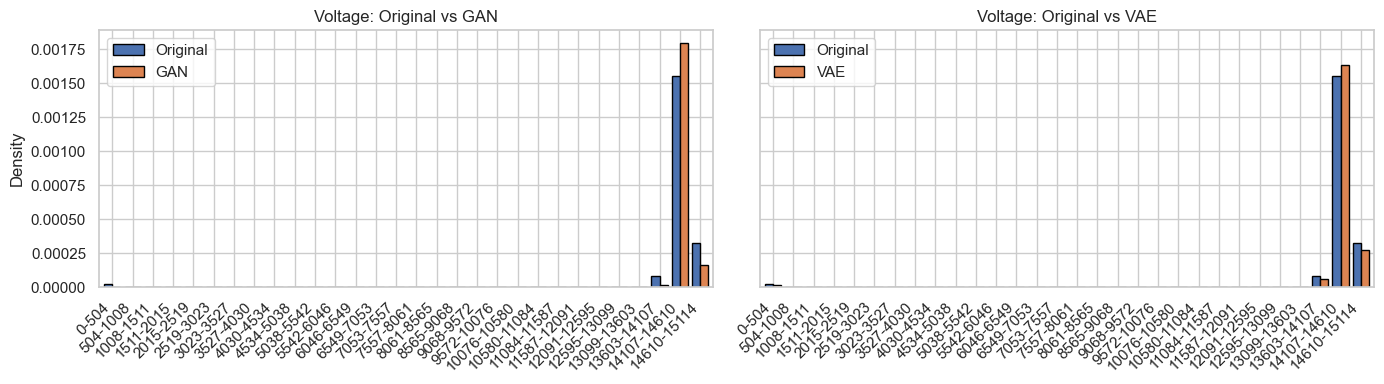

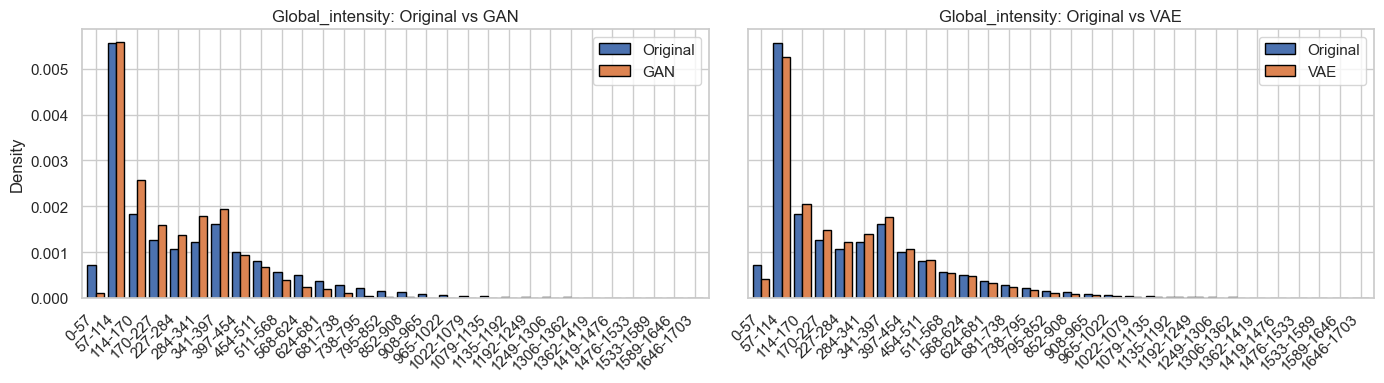

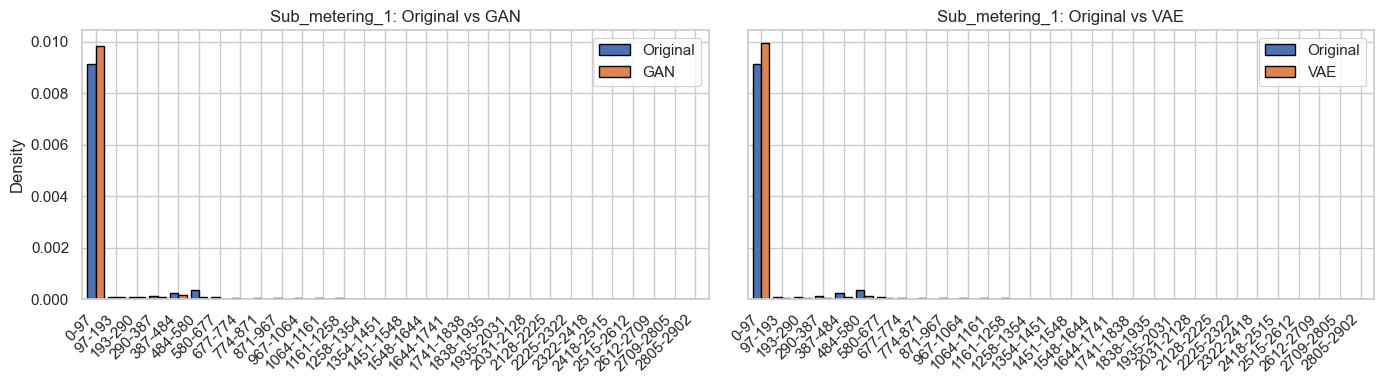

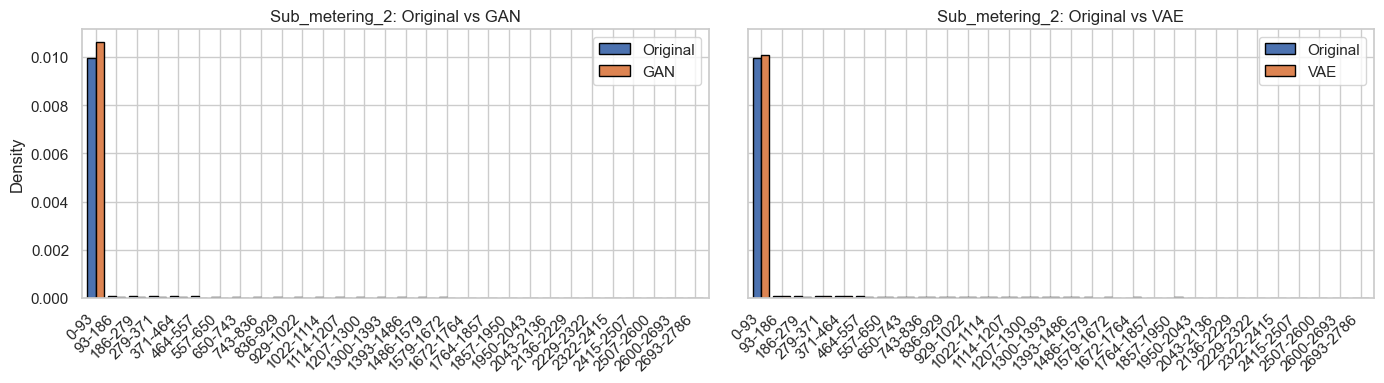

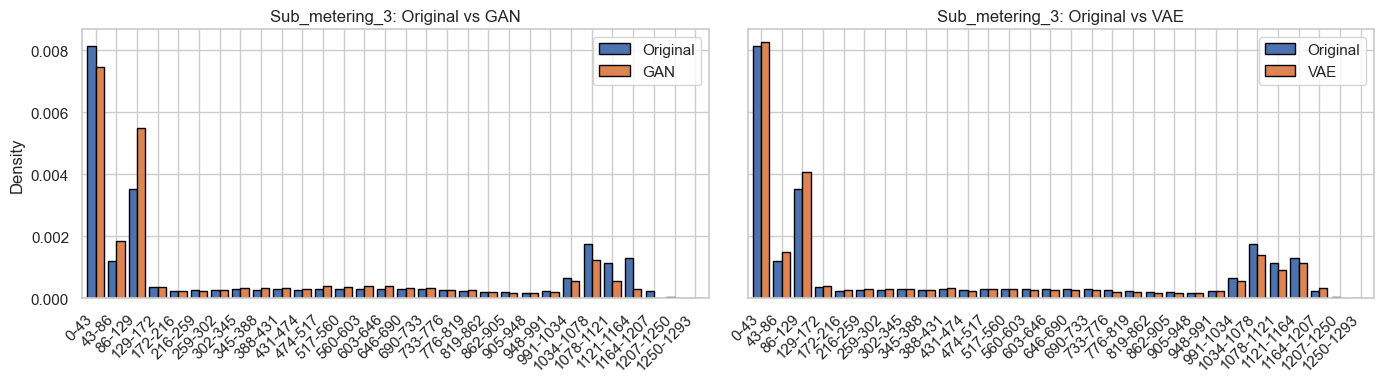

In [210]:
for col in [
    key
    for key, value in household_dataset_metadata.items()
    if value.data_type in (DataType.DECIMAL, DataType.INTEGER)
]:
    orig_vals = household_dataset[col].dropna().values
    gan_vals = S_gan_full[col].dropna().values
    vae_vals = S_vae_full[col].dropna().values

    # Define common bins based on original data
    bins = np.histogram_bin_edges(orig_vals, bins=30)

    # Compute a normalized histogram (density) for each dataset
    orig_counts, _ = np.histogram(orig_vals, bins=bins, density=True)
    gan_counts, _ = np.histogram(gan_vals, bins=bins, density=True)
    vae_counts, _ = np.histogram(vae_vals, bins=bins, density=True)

    # Create bin labels
    bin_labels = [f"{bins[i]:.0f}-{bins[i+1]:.0f}" for i in range(len(bins) - 1)]

    # Build DataFrames for plotting
    df_og = pd.DataFrame({"Original": orig_counts, "GAN": gan_counts}, index=bin_labels)
    df_ov = pd.DataFrame({"Original": orig_counts, "VAE": vae_counts}, index=bin_labels)

    # Plot side-by-side bar charts
    fig, axes = plt.subplots(1, 2, figsize=(14, 4), sharey=True)

    df_og.plot(kind="bar", ax=axes[0], width=0.8, edgecolor="black")
    axes[0].set_title(f"{col}: Original vs GAN")
    axes[0].set_ylabel("Density")

    df_ov.plot(kind="bar", ax=axes[1], width=0.8, edgecolor="black")
    axes[1].set_title(f"{col}: Original vs VAE")

    for ax in axes:
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
        ax.legend()
    plt.tight_layout()
    plt.show()

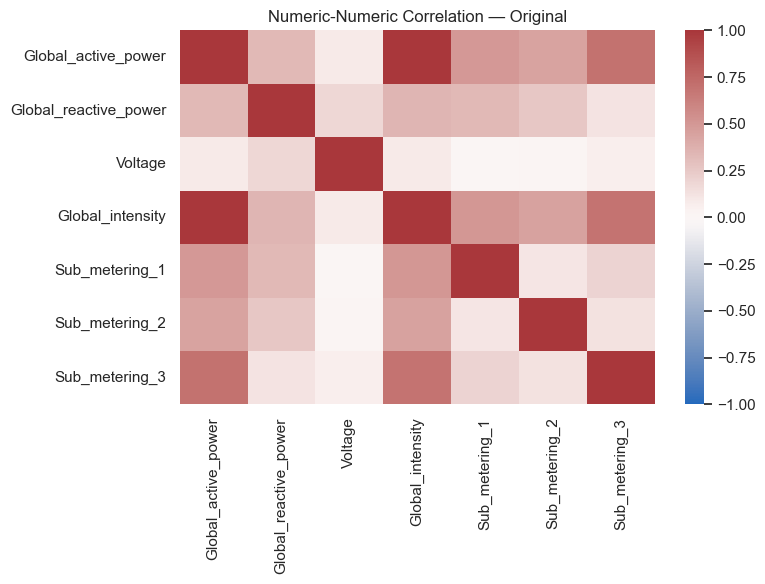

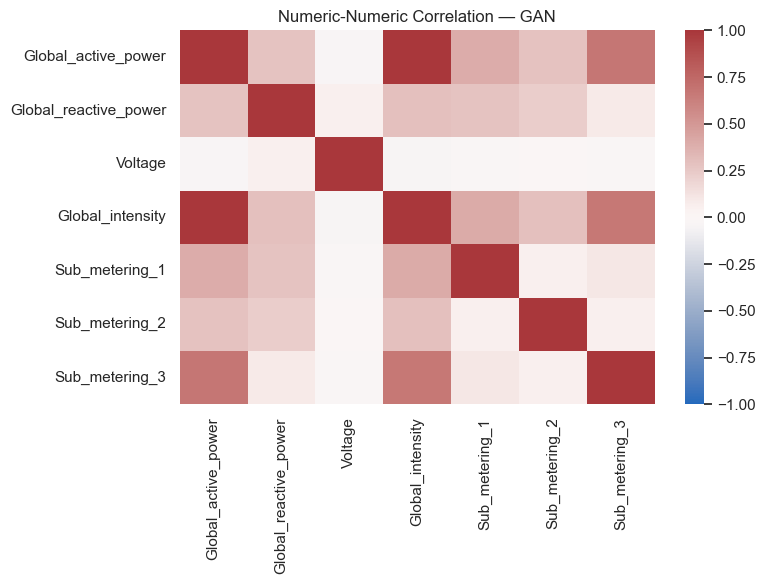

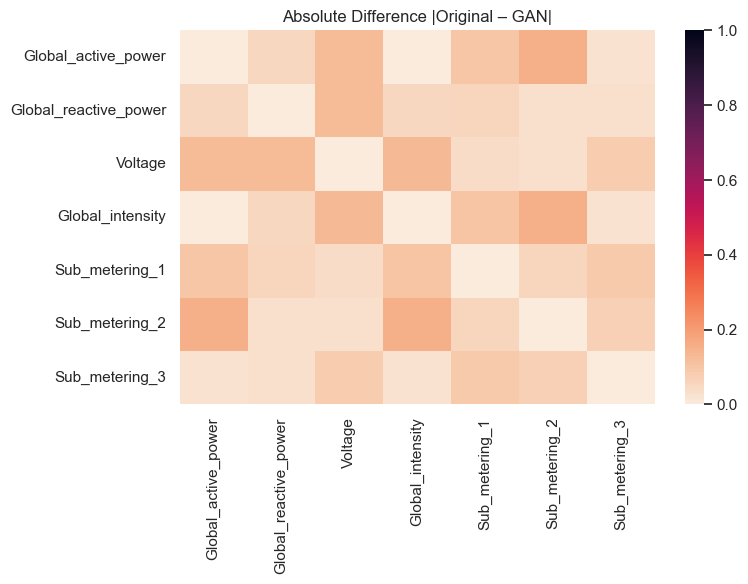

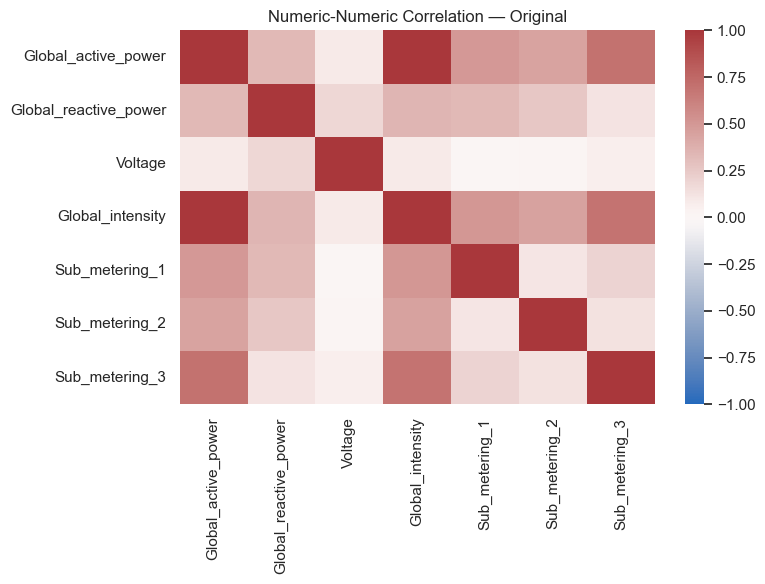

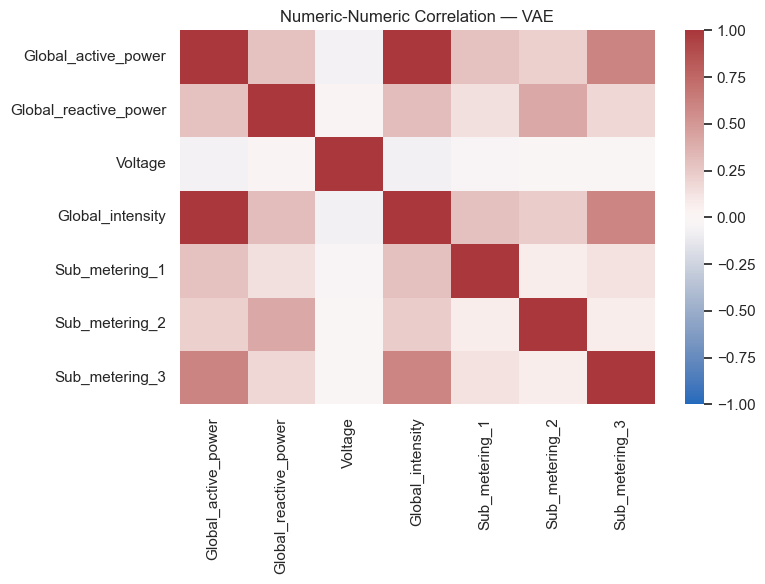

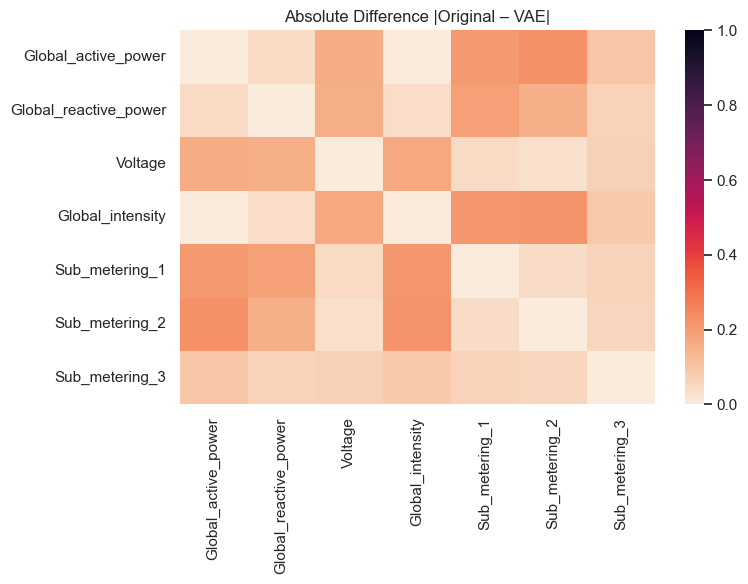

In [214]:
correlation_num_to_num_matrix_plot(
    household_dataset,
    S_gan_full,
    [
        key
        for key, value in household_dataset_metadata.items()
        if value.data_type in (DataType.DECIMAL, DataType.INTEGER)
    ],
    "GAN",
)
correlation_num_to_num_matrix_plot(
    household_dataset,
    S_vae_full,
    [
        key
        for key, value in household_dataset_metadata.items()
        if value.data_type in (DataType.DECIMAL, DataType.INTEGER)
    ],
    "VAE",
)

## 8. Short‑Term Forecasting with ARIMA

### Load & pre-process the real series

In [308]:
df = pd.read_csv(
    "datasets/household_power_consumption.csv", sep=";", na_values="?", low_memory=False
)
df["Date_time"] = pd.to_datetime(
    df["Date"].str.strip() + " " + df["Time"].str.strip(),
    format="%d/%m/%Y %H:%M:%S",
    dayfirst=True,
    errors="coerce",
)
y_hour = (
    df.dropna(subset=["Date_time"])
    .set_index("Date_time")["Global_active_power"]
    .resample("h")
    .sum()
    .interpolate("time")
)

MAPE    RMSE
Original   0.836  43.344
ARIMA+GAN  0.740  42.961
ARIMA+VAE  0.734  43.631

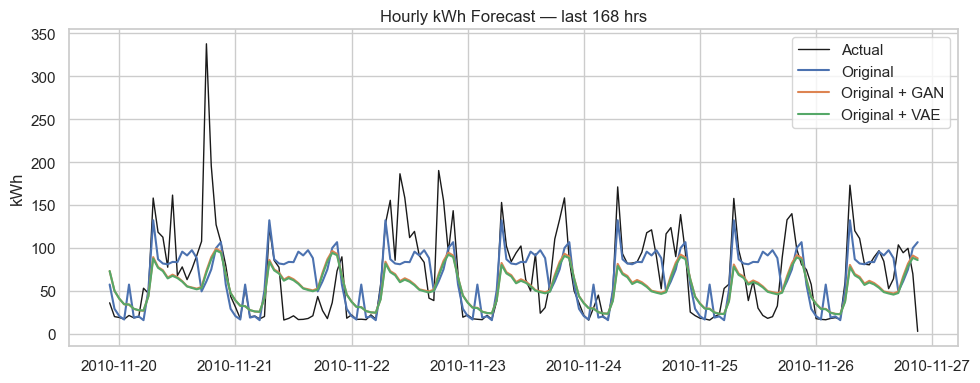

In [215]:
# ignore only the SARIMAX convergence warnings
warnings.simplefilter("ignore", UserWarning)

# ─── 1) Split real data into train / test ─────────────────────────────────
train_orig = y_hour.iloc[:-TEST_H]
test_y = y_hour.iloc[-TEST_H:]

gan_vals = (
    S_gan_full.set_index("Date_time")["Global_active_power"].astype(float).sort_index()
)
vae_vals = (
    S_vae_full.set_index("Date_time")["Global_active_power"].astype(float).sort_index()
)

# ─── 2) Build small GAN/VAE “blocks” and prepend them ────────────────────
train_len = len(train_orig)
block_len = train_len

gan_block = gan_vals.iloc[:block_len]
vae_block = vae_vals.iloc[:block_len]

start_ts = train_orig.index[0]
gan_series = pd.Series(
    gan_block.values,
    index=pd.date_range(
        end=start_ts - pd.Timedelta(hours=1), periods=block_len, freq="h"
    ),
)
vae_series = pd.Series(
    vae_block.values,
    index=pd.date_range(
        end=start_ts - pd.Timedelta(hours=1), periods=block_len, freq="h"
    ),
)

train_gan_ext = pd.concat([gan_series, train_orig]).sort_index()
train_vae_ext = pd.concat([vae_series, train_orig]).sort_index()

# ─── 3) Box–Cox transform all three histories (reuse λ) ────────────────
eps = 1e-6
bc_base = pd.Series(boxcox(train_orig + eps, lmbda=lam), index=train_orig.index)
bc_gan_ext = pd.Series(
    boxcox(train_gan_ext + eps, lmbda=lam), index=train_gan_ext.index
)
bc_vae_ext = pd.Series(
    boxcox(train_vae_ext + eps, lmbda=lam), index=train_vae_ext.index
)

# ─── 4) Fit three SARIMAX models ────────────────────────────────────────
# 4a) “Weakened” ARIMA on original only
cutoff = int(len(bc_base) * 0.999)
y_weak = bc_base.iloc[cutoff:].asfreq("h")
mod_orig = SARIMAX(
    y_weak,
    order=(1, 0, 2),
    seasonal_order=(0, 1, 1, 24),
    enforce_stationarity=False,
    enforce_invertibility=False,
).fit(disp=False)

# Full ARIMA on GAN-extended history
ORDER, SORDER = (2, 0, 2), (1, 1, 1, 24)
mod_gan = SARIMAX(
    bc_gan_ext.asfreq("h"),
    order=ORDER,
    seasonal_order=SORDER,
    initialization="approximate_diffuse",
).fit(disp=False)

# Full ARIMA on VAE-extended history
mod_vae = SARIMAX(
    bc_vae_ext.asfreq("h"),
    order=ORDER,
    seasonal_order=SORDER,
    initialization="approximate_diffuse",
).fit(disp=False)

# Forecast the hold-out
pred_orig_bc = mod_orig.forecast(steps=TEST_H)
pred_gan_bc = mod_gan.forecast(steps=TEST_H)
pred_vae_bc = mod_vae.forecast(steps=TEST_H)

# align indexes to the real test
pred_orig_bc.index = test_y.index
pred_gan_bc.index = test_y.index
pred_vae_bc.index = test_y.index

# Invert Box–Cox back to kWh
inv_bc = lambda x: np.exp(x) if lam == 0 else (x * lam + 1) ** (1 / lam)
pred_orig = pd.Series(inv_bc(pred_orig_bc), index=test_y.index, name="Original")
pred_gan = pd.Series(inv_bc(pred_gan_bc), index=test_y.index, name="ARIMA+GAN")
pred_vae = pd.Series(inv_bc(pred_vae_bc), index=test_y.index, name="ARIMA+VAE")

# Compute and display metrics
scores = pd.DataFrame(
    {
        "MAPE": [
            mean_absolute_percentage_error(test_y, pred_orig),
            mean_absolute_percentage_error(test_y, pred_gan),
            mean_absolute_percentage_error(test_y, pred_vae),
        ],
        "RMSE": [
            np.sqrt(mean_squared_error(test_y, pred_orig)),
            np.sqrt(mean_squared_error(test_y, pred_gan)),
            np.sqrt(mean_squared_error(test_y, pred_vae)),
        ],
    },
    index=["Original", "ARIMA+GAN", "ARIMA+VAE"],
)
display(scores.round(3))

# Plot all three forecasts against actual
plt.figure(figsize=(10, 4))
plt.plot(test_y, label="Actual", color="k", linewidth=1)
plt.plot(pred_orig, label="Original")
plt.plot(pred_gan, label="Original + GAN")
plt.plot(pred_vae, label="Original + VAE")
plt.title(f"Hourly kWh Forecast — last {TEST_H} hrs")
plt.ylabel("kWh")
plt.legend()
plt.tight_layout()
plt.show()